In [1]:
import numpy as np
import matplotlib.pyplot as plt


from hnc import  HNC_solver
from qsps import *


In [2]:
N_bins = 1000

In [3]:
def run_hnc(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3, c_k_guess=None , which_Tij='thermal', method='best'):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    rhos = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    temps = qsp.Tij
    masses= qsp.mij
    hnc1 = HNC_solver(N_species, Gamma, rhos, temps, masses , tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), qsp.βvei(hnc1.r_array)],
                            [qsp.βvei(hnc1.r_array), qsp.βvee(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    if c_k_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_k_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
#                 if i==j:
                    hnc1.c_k_matrix[i,j] = c_k_guess[i,j]
                    hnc1.c_r_matrix[i,j] = hnc1.FT_k_2_r(hnc1.c_k_matrix[i,j])
                    hnc1.c_s_k_matrix[i,j] = hnc1.c_k_matrix[i,j] + hnc1.βu_l_k_matrix[i,j]
                    hnc1.c_s_r_matrix[i,j] = hnc1.c_r_matrix[i,j] + hnc1.βu_l_r_matrix[i,j]

#     print("c asymm: ", hnc1.c_s_k_matrix[1,0]/hnc1.c_s_k_matrix[0,1])
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e8)

    return hnc1, qsp

In [4]:
def run_hnc_one_ion(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best', which_Tij='thermal' ):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["i"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    temps = np.array([[qsp.Ti]])
    masses= np.array([[qsp.m_i]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp

def run_hnc_one_electron(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, alpha = 1e-3,method='best' , which_Tij='thermal'):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri, which_Tij=which_Tij)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["e"] 
    kappa = 1
    rho = np.array([  Zstar*3/(4*np.pi)])
    temps = np.array([[qsp.Te_c]])
    masses= np.array([[m_e]])
    hnc1 = HNC_solver(N_species, Gamma,rho, temps,masses, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvee(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = alpha, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp



# Priority 1
## Carbon

In [5]:
ni = 5.01e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z, A = 6,12
Zstar= 3

# c_s_r_guess = np.zeros((2,2,N_bins))
# c_s_r_guess[0,0] = carbon_one_species.c_s_r_matrix

carbon, carbonqsp = run_hnc(ni, Te, Z, A, Zstar ,method='fixed',alpha=0.5,num_iterations=1e3)#, c_s_r_guess=c_s_r_guess)


Λee = 0.328
Λei = 0.232
Γii=82.957, Γie=-1.499, Γee=0.500 
r_i=1.476
r_e=1.023
θ  =4.18e-02
0: Err in c_r: 1.43e+02, OZ: 1.43e-01, HNC: 1.30e-01, tot: 0.20
1: Err in c_r: 7.83e+01, OZ: 1.34e-01, HNC: 6.16e-02, tot: 0.20
2: Err in c_r: 4.31e+01, OZ: 1.27e-01, HNC: 5.78e-02, tot: 0.23
3: Err in c_r: 2.41e+01, OZ: 1.23e-01, HNC: 7.00e-02, tot: 0.26
4: Err in c_r: 1.39e+01, OZ: 1.21e-01, HNC: 9.32e-02, tot: 0.29
5: Err in c_r: 8.38e+00, OZ: 1.20e-01, HNC: 1.26e-01, tot: 0.34
6: Err in c_r: 5.41e+00, OZ: 1.19e-01, HNC: 1.57e-01, tot: 0.38
7: Err in c_r: 3.77e+00, OZ: 1.17e-01, HNC: 1.82e-01, tot: 0.42
8: Err in c_r: 2.82e+00, OZ: 1.16e-01, HNC: 2.03e-01, tot: 0.45
9: Err in c_r: 2.23e+00, OZ: 1.14e-01, HNC: 2.20e-01, tot: 0.49
10: Err in c_r: 1.85e+00, OZ: 1.13e-01, HNC: 2.35e-01, tot: 0.52
11: Err in c_r: 1.58e+00, OZ: 1.11e-01, HNC: 2.50e-01, tot: 0.55
12: Err in c_r: 1.38e+00, OZ: 1.09e-01, HNC: 2.64e-01, tot: 0.58
13: Err in c_r: 1.22e+00, OZ: 1.07e-01, HNC: 2.79e-01, tot: 0.61
14: Err 

132: Err in c_r: 9.44e-03, OZ: 4.96e-03, HNC: 3.30e-02, tot: 2.09
133: Err in c_r: 9.17e-03, OZ: 4.82e-03, HNC: 3.21e-02, tot: 2.09
134: Err in c_r: 8.90e-03, OZ: 4.68e-03, HNC: 3.11e-02, tot: 2.09
135: Err in c_r: 8.63e-03, OZ: 4.55e-03, HNC: 3.02e-02, tot: 2.09
136: Err in c_r: 8.38e-03, OZ: 4.42e-03, HNC: 2.93e-02, tot: 2.09
137: Err in c_r: 8.13e-03, OZ: 4.29e-03, HNC: 2.84e-02, tot: 2.09
138: Err in c_r: 7.89e-03, OZ: 4.17e-03, HNC: 2.76e-02, tot: 2.10
139: Err in c_r: 7.66e-03, OZ: 4.05e-03, HNC: 2.68e-02, tot: 2.10
140: Err in c_r: 7.44e-03, OZ: 3.94e-03, HNC: 2.60e-02, tot: 2.10
141: Err in c_r: 7.22e-03, OZ: 3.83e-03, HNC: 2.52e-02, tot: 2.10
142: Err in c_r: 7.01e-03, OZ: 3.72e-03, HNC: 2.45e-02, tot: 2.10
143: Err in c_r: 6.80e-03, OZ: 3.61e-03, HNC: 2.38e-02, tot: 2.10
144: Err in c_r: 6.61e-03, OZ: 3.51e-03, HNC: 2.31e-02, tot: 2.10
145: Err in c_r: 6.41e-03, OZ: 3.41e-03, HNC: 2.24e-02, tot: 2.10
146: Err in c_r: 6.23e-03, OZ: 3.32e-03, HNC: 2.18e-02, tot: 2.10
147: Err i

265: Err in c_r: 2.00e-04, OZ: 1.09e-04, HNC: 6.96e-04, tot: 2.13
266: Err in c_r: 1.94e-04, OZ: 1.06e-04, HNC: 6.77e-04, tot: 2.13
267: Err in c_r: 1.88e-04, OZ: 1.03e-04, HNC: 6.58e-04, tot: 2.13
268: Err in c_r: 1.83e-04, OZ: 1.00e-04, HNC: 6.39e-04, tot: 2.13
269: Err in c_r: 1.78e-04, OZ: 9.74e-05, HNC: 6.21e-04, tot: 2.13
270: Err in c_r: 1.73e-04, OZ: 9.46e-05, HNC: 6.03e-04, tot: 2.13
271: Err in c_r: 1.68e-04, OZ: 9.20e-05, HNC: 5.86e-04, tot: 2.13
272: Err in c_r: 1.63e-04, OZ: 8.94e-05, HNC: 5.70e-04, tot: 2.13
273: Err in c_r: 1.59e-04, OZ: 8.69e-05, HNC: 5.54e-04, tot: 2.13
274: Err in c_r: 1.54e-04, OZ: 8.44e-05, HNC: 5.38e-04, tot: 2.13
275: Err in c_r: 1.50e-04, OZ: 8.20e-05, HNC: 5.23e-04, tot: 2.13
276: Err in c_r: 1.46e-04, OZ: 7.97e-05, HNC: 5.08e-04, tot: 2.13
277: Err in c_r: 1.41e-04, OZ: 7.74e-05, HNC: 4.94e-04, tot: 2.13
278: Err in c_r: 1.37e-04, OZ: 7.53e-05, HNC: 4.80e-04, tot: 2.13
279: Err in c_r: 1.34e-04, OZ: 7.31e-05, HNC: 4.66e-04, tot: 2.13
280: Err i

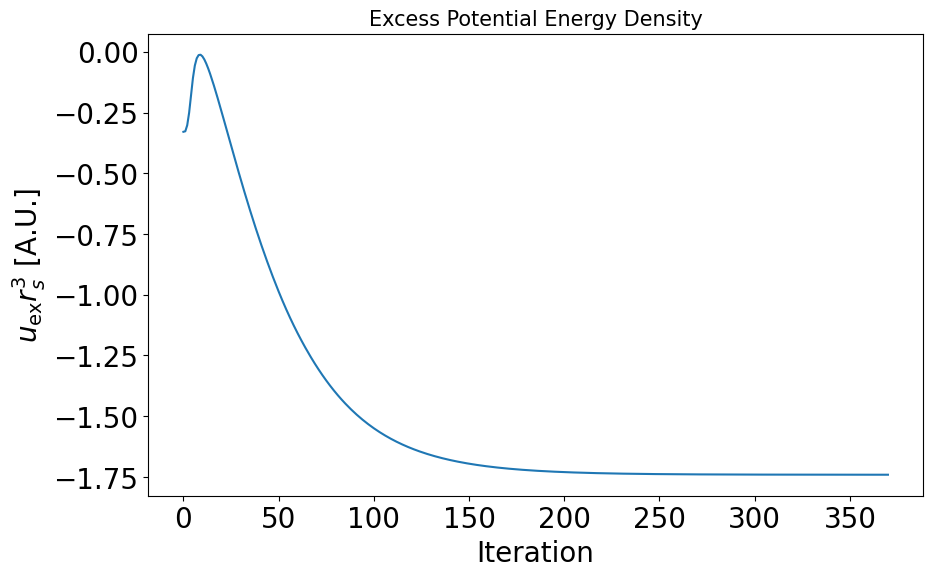

In [6]:
carbon.plot_convergence_uex()

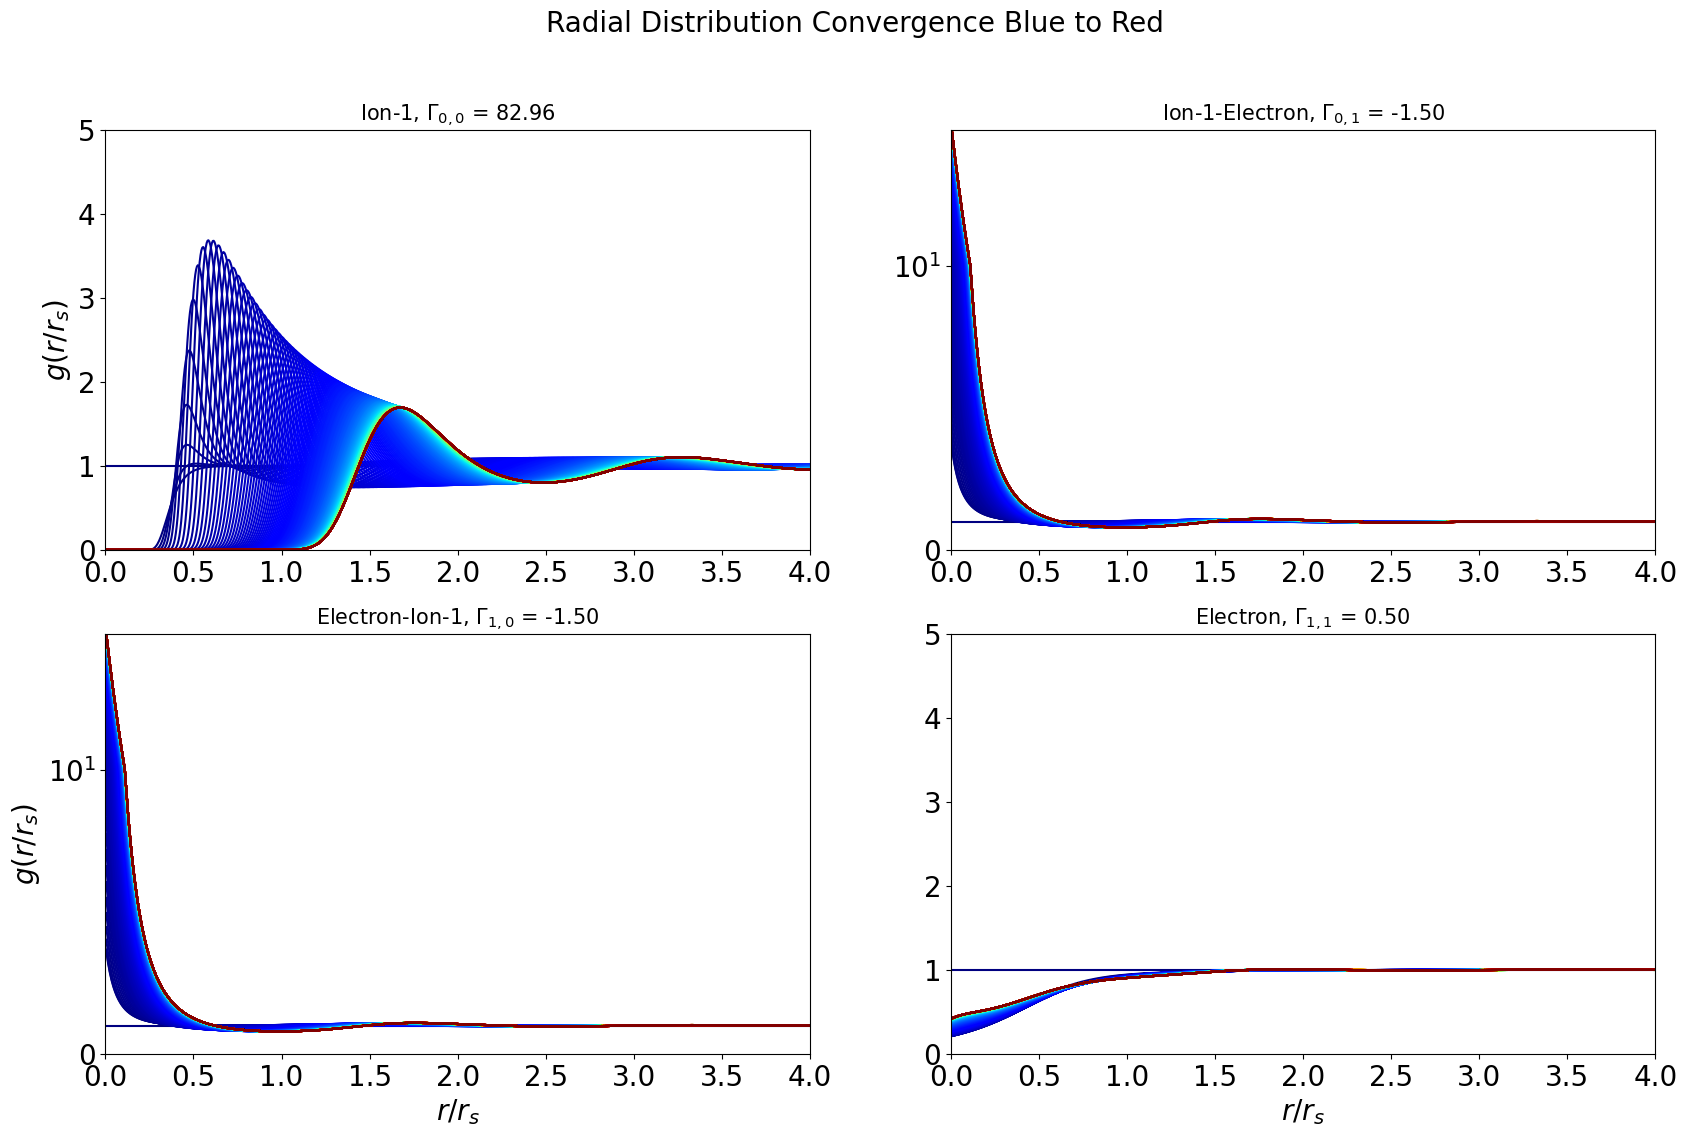

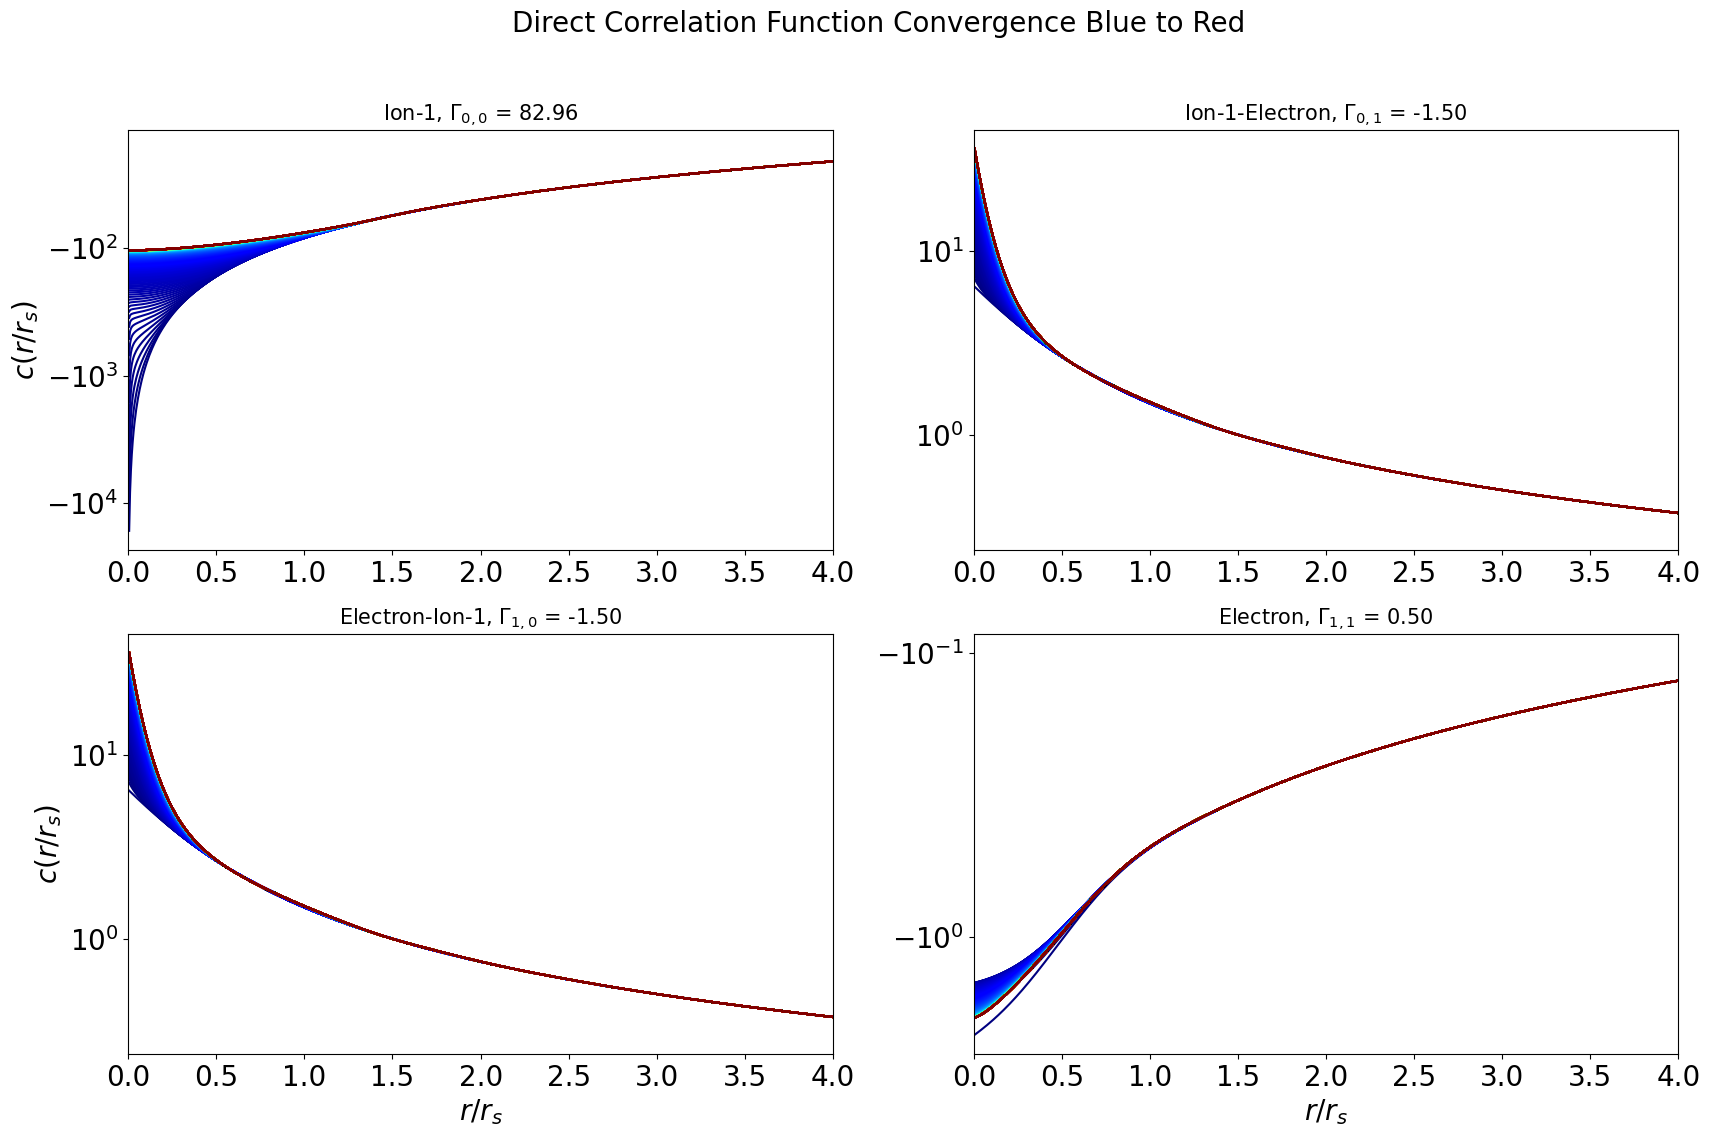

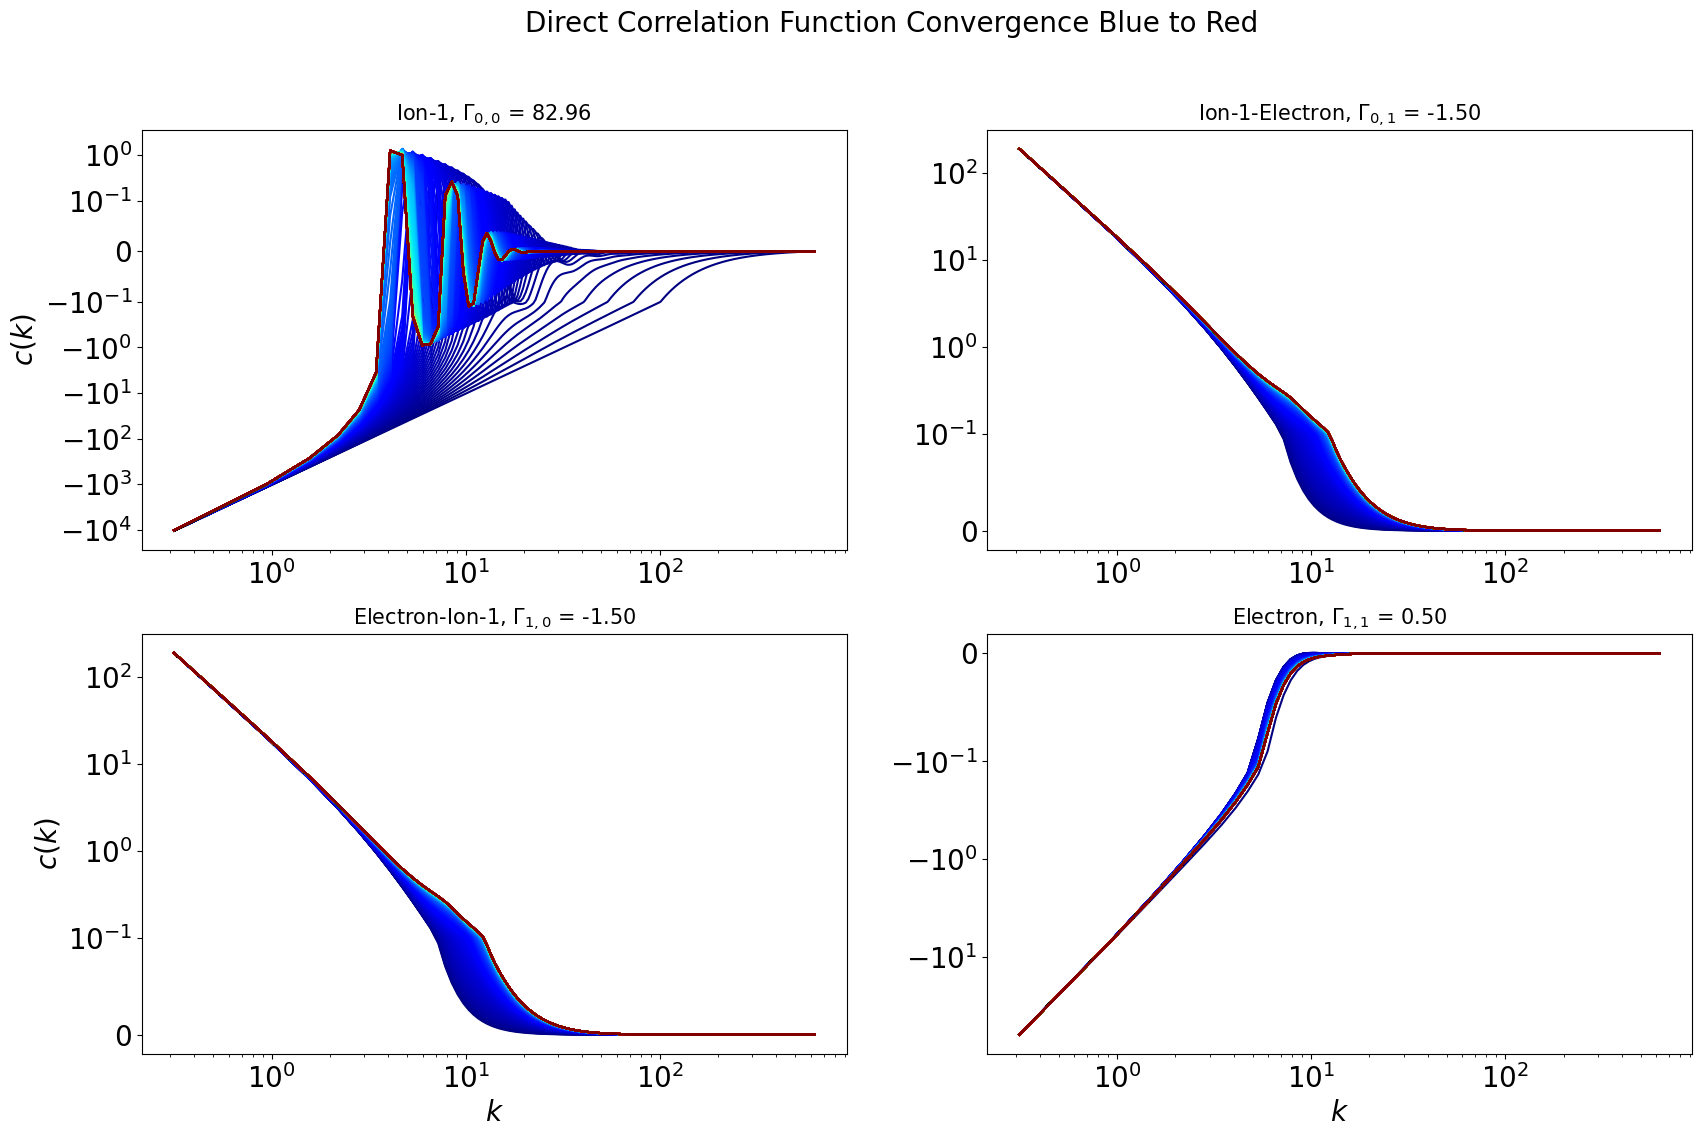

In [7]:
carbon.plot_species_convergence_g(n_slices= int(len(carbon.h_list)/1)  )
carbon.plot_species_convergence_c(n_slices= int(len(carbon.h_list)/1)  )
carbon.plot_species_convergence_ck(n_slices= int(len(carbon.h_list)/1)  )

In [16]:
carbon_one_species, _ = run_hnc_one_species(ni, Te, Z, A, Zstar )

NameError: name 'run_hnc_one_species' is not defined

In [ ]:
carbon.plot_g_vs_murillo()
carbon.plot_g_vs_murillo(gmax=3)

In [ ]:
fig, ax = plt.subplots()

ax.plot(carbon.r_array, carbon.h_r_matrix[0,0]+1, label='Ion and Electron')
ax.plot(carbon.r_array, carbon_one_species.h_r_matrix[0,0]+1, label="Ion only")
ax.legend()



## Copper

In [9]:
ni = 8.49e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 29,63.55
Zstar= 1.206


copper,_ = run_hnc(ni, Te, Z, A, Zstar ,num_iterations=1e3, method='fixed', alpha=0.1)

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
0: Err in c_r: 5.54e+00, OZ: 1.49e-01, HNC: 5.17e+00, tot: 0.44
1: Err in c_r: 5.02e+00, OZ: 1.46e-01, HNC: 3.59e+00, tot: 0.43
2: Err in c_r: 4.54e+00, OZ: 1.43e-01, HNC: 2.69e+00, tot: 0.43
3: Err in c_r: 4.11e+00, OZ: 1.40e-01, HNC: 2.14e+00, tot: 0.44
4: Err in c_r: 3.72e+00, OZ: 1.38e-01, HNC: 1.78e+00, tot: 0.44
5: Err in c_r: 3.37e+00, OZ: 1.35e-01, HNC: 1.55e+00, tot: 0.45
6: Err in c_r: 3.05e+00, OZ: 1.33e-01, HNC: 1.39e+00, tot: 0.46
7: Err in c_r: 2.76e+00, OZ: 1.30e-01, HNC: 1.28e+00, tot: 0.46
8: Err in c_r: 2.50e+00, OZ: 1.28e-01, HNC: 1.20e+00, tot: 0.47
9: Err in c_r: 2.26e+00, OZ: 1.26e-01, HNC: 1.16e+00, tot: 0.48
10: Err in c_r: 2.05e+00, OZ: 1.24e-01, HNC: 1.13e+00, tot: 0.49
11: Err in c_r: 1.85e+00, OZ: 1.22e-01, HNC: 1.13e+00, tot: 0.50
12: Err in c_r: 1.68e+00, OZ: 1.20e-01, HNC: 1.13e+00, tot: 0.52
13: Err in c_r: 1.52e+00, OZ: 1.18e-01, HNC: 1.15e+00, tot: 0.53
14: Err 

135: Err in c_r: 3.75e-03, OZ: 1.27e-02, HNC: 2.68e-01, tot: 1.49
136: Err in c_r: 3.66e-03, OZ: 1.24e-02, HNC: 2.62e-01, tot: 1.49
137: Err in c_r: 3.58e-03, OZ: 1.22e-02, HNC: 2.55e-01, tot: 1.49
138: Err in c_r: 3.49e-03, OZ: 1.19e-02, HNC: 2.49e-01, tot: 1.49
139: Err in c_r: 3.41e-03, OZ: 1.17e-02, HNC: 2.43e-01, tot: 1.49
140: Err in c_r: 3.33e-03, OZ: 1.14e-02, HNC: 2.37e-01, tot: 1.50
141: Err in c_r: 3.25e-03, OZ: 1.12e-02, HNC: 2.31e-01, tot: 1.50
142: Err in c_r: 3.18e-03, OZ: 1.09e-02, HNC: 2.25e-01, tot: 1.50
143: Err in c_r: 3.11e-03, OZ: 1.07e-02, HNC: 2.20e-01, tot: 1.50
144: Err in c_r: 3.03e-03, OZ: 1.05e-02, HNC: 2.14e-01, tot: 1.50
145: Err in c_r: 2.96e-03, OZ: 1.03e-02, HNC: 2.09e-01, tot: 1.50
146: Err in c_r: 2.89e-03, OZ: 1.00e-02, HNC: 2.04e-01, tot: 1.50
147: Err in c_r: 2.83e-03, OZ: 9.82e-03, HNC: 1.99e-01, tot: 1.50
148: Err in c_r: 2.76e-03, OZ: 9.61e-03, HNC: 1.94e-01, tot: 1.50
149: Err in c_r: 2.70e-03, OZ: 9.41e-03, HNC: 1.89e-01, tot: 1.51
150: Err i

274: Err in c_r: 1.61e-04, OZ: 6.05e-04, HNC: 1.08e-02, tot: 1.55
275: Err in c_r: 1.57e-04, OZ: 5.92e-04, HNC: 1.06e-02, tot: 1.55
276: Err in c_r: 1.54e-04, OZ: 5.79e-04, HNC: 1.03e-02, tot: 1.55
277: Err in c_r: 1.50e-04, OZ: 5.66e-04, HNC: 1.01e-02, tot: 1.55
278: Err in c_r: 1.47e-04, OZ: 5.54e-04, HNC: 9.88e-03, tot: 1.55
279: Err in c_r: 1.44e-04, OZ: 5.42e-04, HNC: 9.67e-03, tot: 1.55
280: Err in c_r: 1.41e-04, OZ: 5.30e-04, HNC: 9.45e-03, tot: 1.55
281: Err in c_r: 1.38e-04, OZ: 5.18e-04, HNC: 9.24e-03, tot: 1.55
282: Err in c_r: 1.35e-04, OZ: 5.07e-04, HNC: 9.04e-03, tot: 1.55
283: Err in c_r: 1.32e-04, OZ: 4.96e-04, HNC: 8.84e-03, tot: 1.55
284: Err in c_r: 1.29e-04, OZ: 4.85e-04, HNC: 8.65e-03, tot: 1.55
285: Err in c_r: 1.26e-04, OZ: 4.74e-04, HNC: 8.46e-03, tot: 1.55
286: Err in c_r: 1.23e-04, OZ: 4.64e-04, HNC: 8.27e-03, tot: 1.55
287: Err in c_r: 1.20e-04, OZ: 4.54e-04, HNC: 8.09e-03, tot: 1.55
288: Err in c_r: 1.18e-04, OZ: 4.44e-04, HNC: 7.91e-03, tot: 1.55
289: Err i

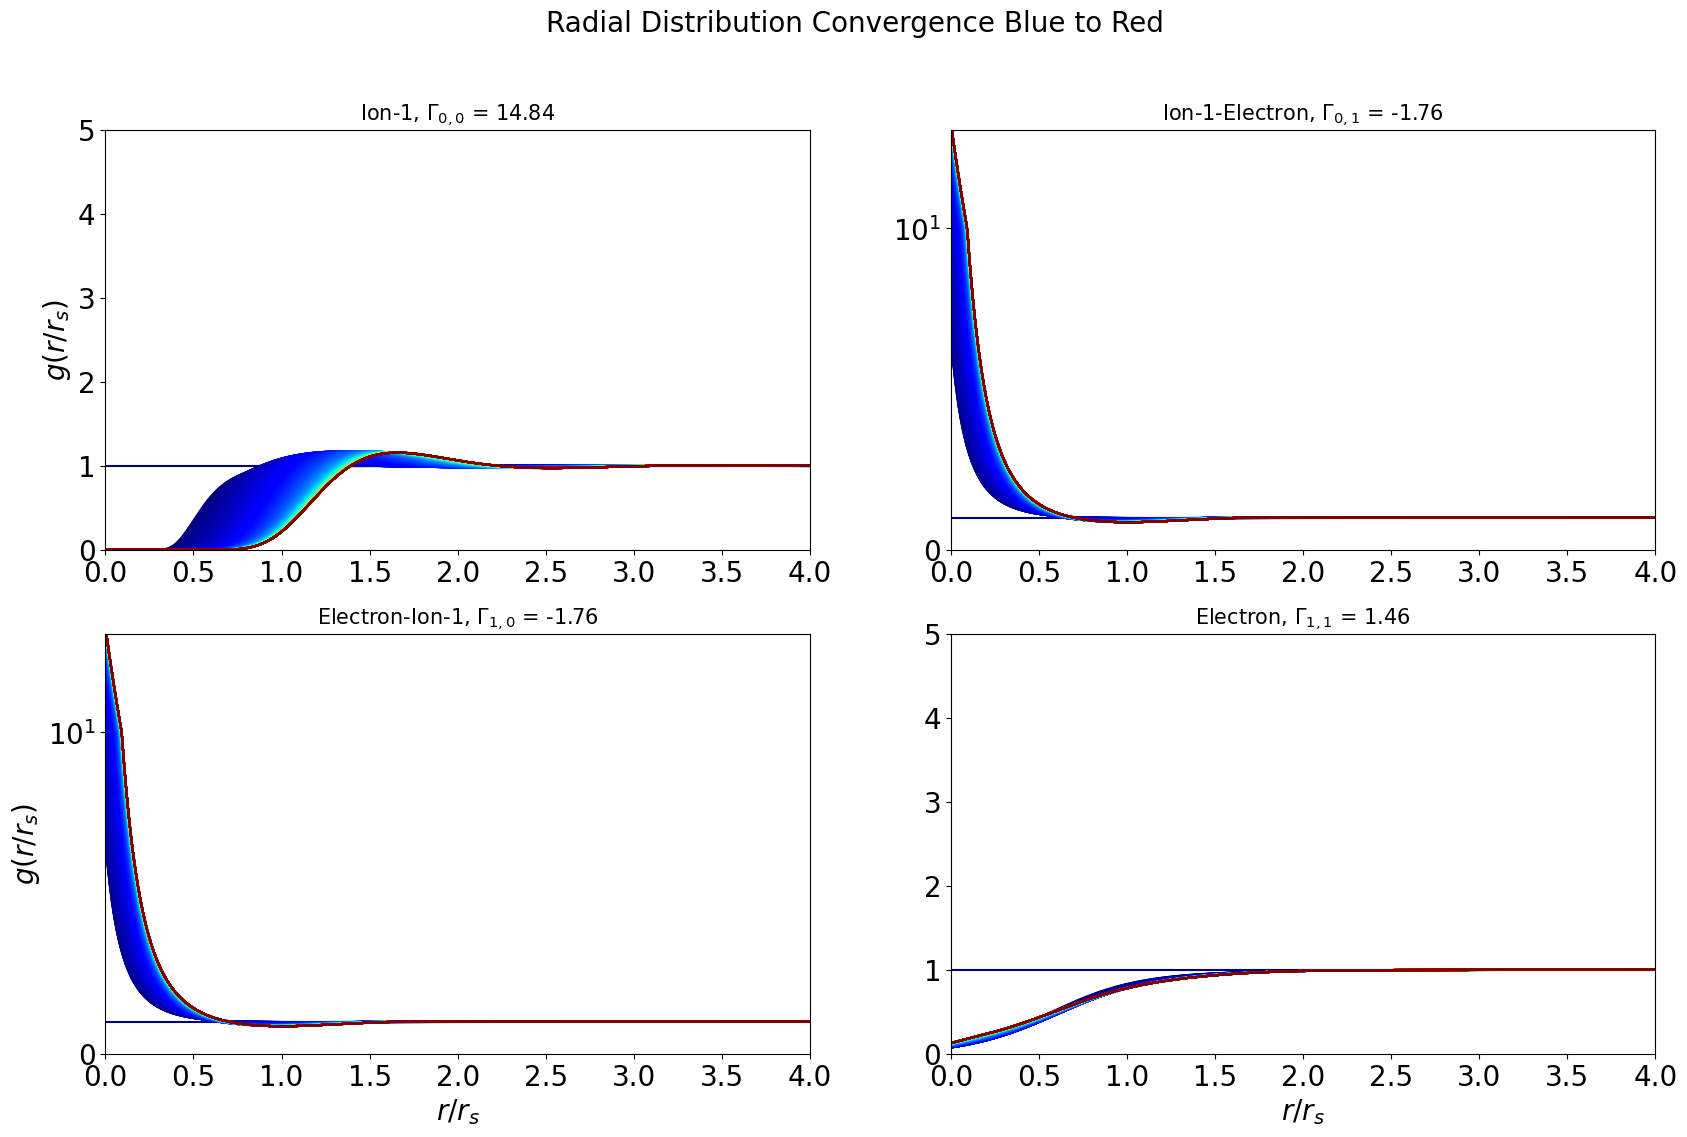

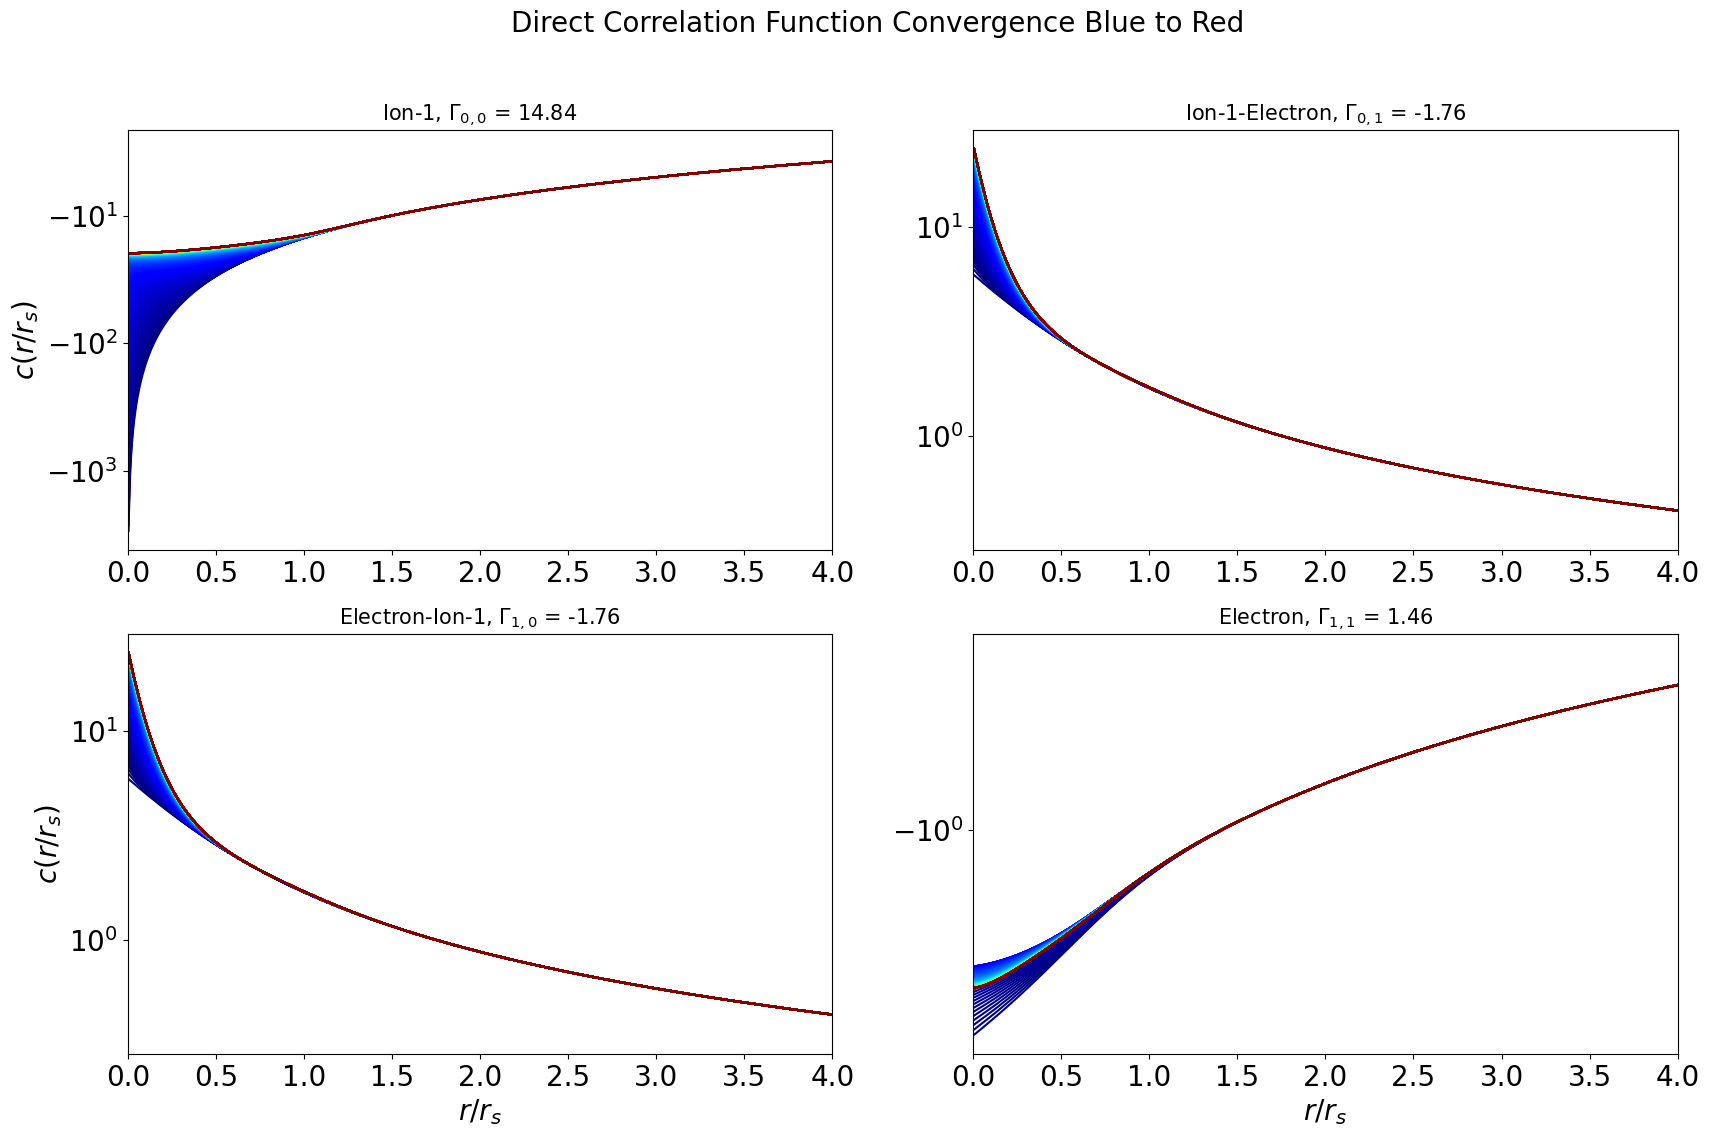

In [10]:
copper.plot_species_convergence_g(n_slices= int(len(copper.h_list)/1)  )
copper.plot_species_convergence_c(n_slices= int(len(copper.h_list)/1)  )

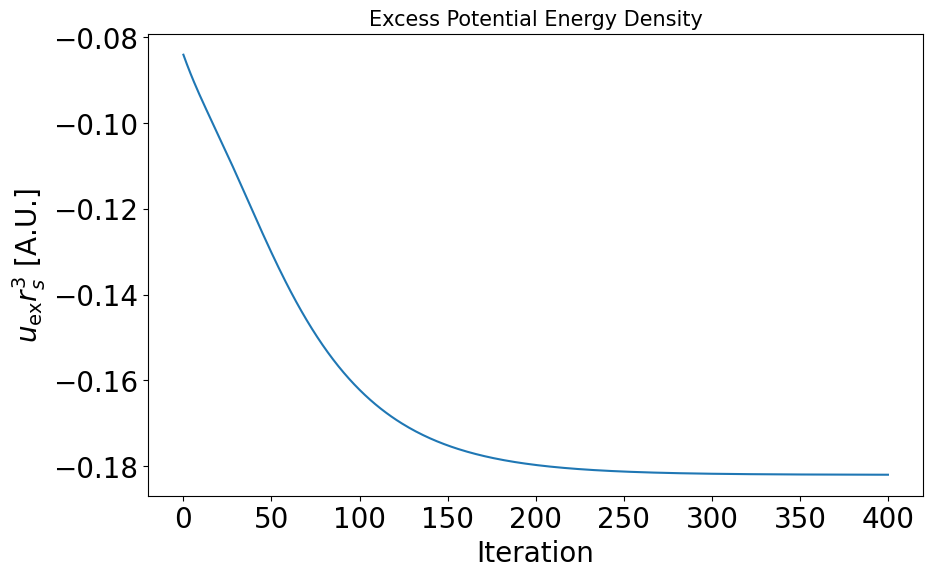

In [11]:
copper.plot_convergence_uex()

In [26]:
copper_one_species,_ = run_hnc_one_species(ni, Te, Z, A, Zstar )

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00313886] True Optimization terminated successfully.
0: Err in c_r: 5.56e+01, OZ: 1.54e-01, HNC: 1.60e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 2.90e+01, OZ: 1.45e-01, HNC: 1.15e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 1.52e+01, OZ: 1.34e-01, HNC: 9.94e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 8.05e+00, OZ: 1.25e-01, HNC: 9.62e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 4.34e+00, OZ: 1.17e-01, HNC: 9.65e-03
 HNC min: [0.5] True Optimization terminated succe

 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 2.06e-03, OZ: 9.59e-04, HNC: 9.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 1.85e-03, OZ: 8.61e-04, HNC: 8.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
54: Err in c_r: 1.66e-03, OZ: 7.72e-04, HNC: 7.82e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
55: Err in c_r: 1.49e-03, OZ: 6.93e-04, HNC: 7.02e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
56: Err in c_r: 1.34e-03, OZ: 6.22e-04, HNC: 6.29e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
57: Err in c_r: 1.20e-03, OZ: 5.58e-04, HNC: 5.65e-05
 HNC min: [0.5] True Optimization

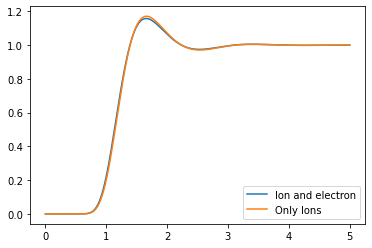

In [27]:
fig, ax = plt.subplots()

ax.plot(copper.r_array, copper.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(copper.r_array, copper_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



## Hydrogen

In [15]:
ni = 5.98e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z, A = 1,1
Zstar= 1
hydrogen, _ = run_hnc(ni, Te, Z, A, Zstar ,method='fixed',alpha=0.1)

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
0: Err in c_r: 3.70e+00, OZ: 1.25e-01, HNC: 1.26e-01, tot: 0.25
1: Err in c_r: 3.34e+00, OZ: 1.22e-01, HNC: 1.13e-01, tot: 0.26
2: Err in c_r: 3.02e+00, OZ: 1.20e-01, HNC: 1.03e-01, tot: 0.26
3: Err in c_r: 2.73e+00, OZ: 1.17e-01, HNC: 9.42e-02, tot: 0.26
4: Err in c_r: 2.47e+00, OZ: 1.14e-01, HNC: 8.73e-02, tot: 0.27
5: Err in c_r: 2.24e+00, OZ: 1.11e-01, HNC: 8.17e-02, tot: 0.27
6: Err in c_r: 2.02e+00, OZ: 1.09e-01, HNC: 7.70e-02, tot: 0.27
7: Err in c_r: 1.83e+00, OZ: 1.07e-01, HNC: 7.32e-02, tot: 0.28
8: Err in c_r: 1.65e+00, OZ: 1.04e-01, HNC: 7.00e-02, tot: 0.28
9: Err in c_r: 1.49e+00, OZ: 1.02e-01, HNC: 6.74e-02, tot: 0.28
10: Err in c_r: 1.35e+00, OZ: 9.98e-02, HNC: 6.52e-02, tot: 0.28
11: Err in c_r: 1.22e+00, OZ: 9.77e-02, HNC: 6.35e-02, tot: 0.29
12: Err in c_r: 1.10e+00, OZ: 9.56e-02, HNC: 6.21e-02, tot: 0.29
13: Err in c_r: 9.99e-01, OZ: 9.36e-02, HNC: 6.10e-02, tot: 0.29
14: Err i

135: Err in c_r: 1.25e-03, OZ: 4.69e-03, HNC: 4.09e-03, tot: 0.43
136: Err in c_r: 1.21e-03, OZ: 4.56e-03, HNC: 3.98e-03, tot: 0.43
137: Err in c_r: 1.18e-03, OZ: 4.44e-03, HNC: 3.87e-03, tot: 0.43
138: Err in c_r: 1.14e-03, OZ: 4.32e-03, HNC: 3.76e-03, tot: 0.43
139: Err in c_r: 1.11e-03, OZ: 4.20e-03, HNC: 3.66e-03, tot: 0.43
140: Err in c_r: 1.08e-03, OZ: 4.09e-03, HNC: 3.56e-03, tot: 0.43
141: Err in c_r: 1.05e-03, OZ: 3.98e-03, HNC: 3.46e-03, tot: 0.43
142: Err in c_r: 1.02e-03, OZ: 3.87e-03, HNC: 3.36e-03, tot: 0.43
143: Err in c_r: 9.92e-04, OZ: 3.77e-03, HNC: 3.27e-03, tot: 0.43
144: Err in c_r: 9.65e-04, OZ: 3.67e-03, HNC: 3.18e-03, tot: 0.43
145: Err in c_r: 9.38e-04, OZ: 3.57e-03, HNC: 3.09e-03, tot: 0.43
146: Err in c_r: 9.11e-04, OZ: 3.47e-03, HNC: 3.01e-03, tot: 0.43
147: Err in c_r: 8.86e-04, OZ: 3.38e-03, HNC: 2.93e-03, tot: 0.43
148: Err in c_r: 8.61e-04, OZ: 3.29e-03, HNC: 2.85e-03, tot: 0.43
149: Err in c_r: 8.37e-04, OZ: 3.20e-03, HNC: 2.77e-03, tot: 0.43
150: Err i

275: Err in c_r: 2.51e-05, OZ: 9.91e-05, HNC: 8.40e-05, tot: 0.43
276: Err in c_r: 2.44e-05, OZ: 9.64e-05, HNC: 8.17e-05, tot: 0.43
277: Err in c_r: 2.38e-05, OZ: 9.38e-05, HNC: 7.95e-05, tot: 0.43
278: Err in c_r: 2.31e-05, OZ: 9.12e-05, HNC: 7.73e-05, tot: 0.43
279: Err in c_r: 2.25e-05, OZ: 8.87e-05, HNC: 7.52e-05, tot: 0.43
280: Err in c_r: 2.19e-05, OZ: 8.63e-05, HNC: 7.32e-05, tot: 0.43
281: Err in c_r: 2.13e-05, OZ: 8.39e-05, HNC: 7.12e-05, tot: 0.43
282: Err in c_r: 2.07e-05, OZ: 8.17e-05, HNC: 6.92e-05, tot: 0.43
283: Err in c_r: 2.01e-05, OZ: 7.94e-05, HNC: 6.73e-05, tot: 0.43
284: Err in c_r: 1.96e-05, OZ: 7.73e-05, HNC: 6.55e-05, tot: 0.43
285: Err in c_r: 1.90e-05, OZ: 7.52e-05, HNC: 6.37e-05, tot: 0.43
286: Err in c_r: 1.85e-05, OZ: 7.31e-05, HNC: 6.20e-05, tot: 0.43
287: Err in c_r: 1.80e-05, OZ: 7.11e-05, HNC: 6.03e-05, tot: 0.43
288: Err in c_r: 1.75e-05, OZ: 6.92e-05, HNC: 5.86e-05, tot: 0.43
289: Err in c_r: 1.70e-05, OZ: 6.73e-05, HNC: 5.70e-05, tot: 0.43
290: Err i

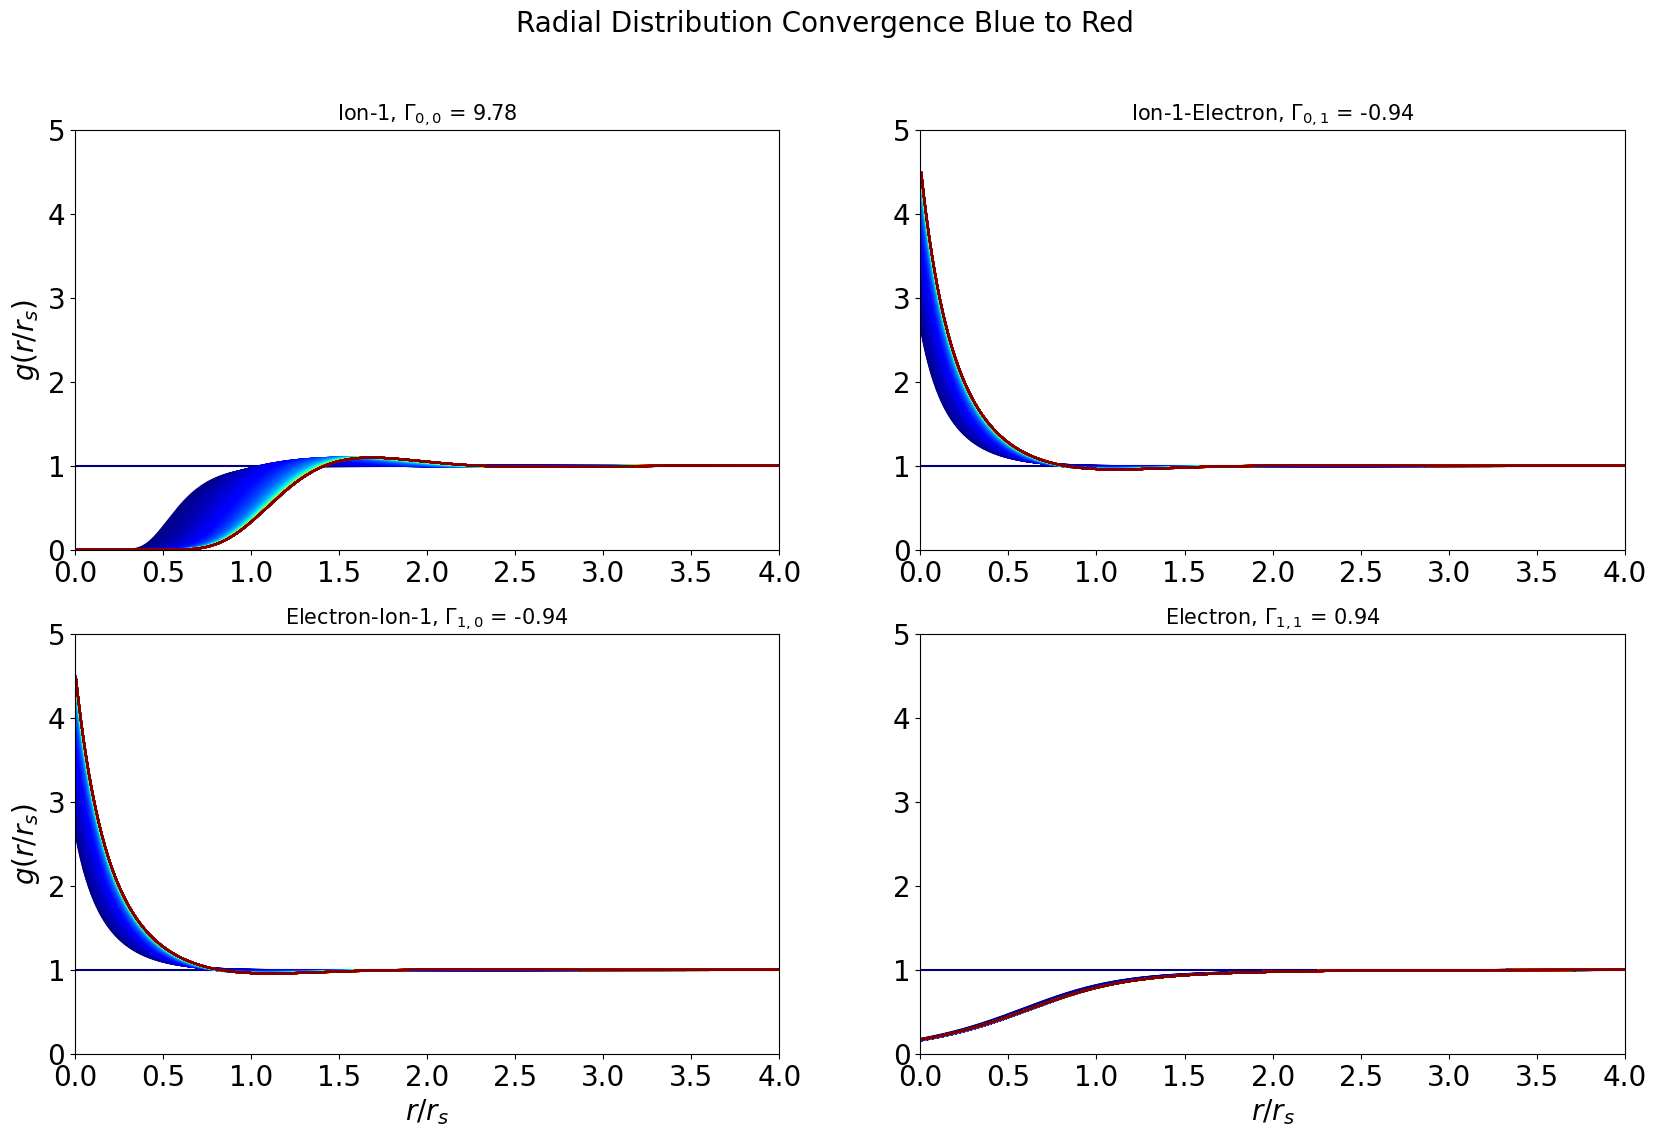

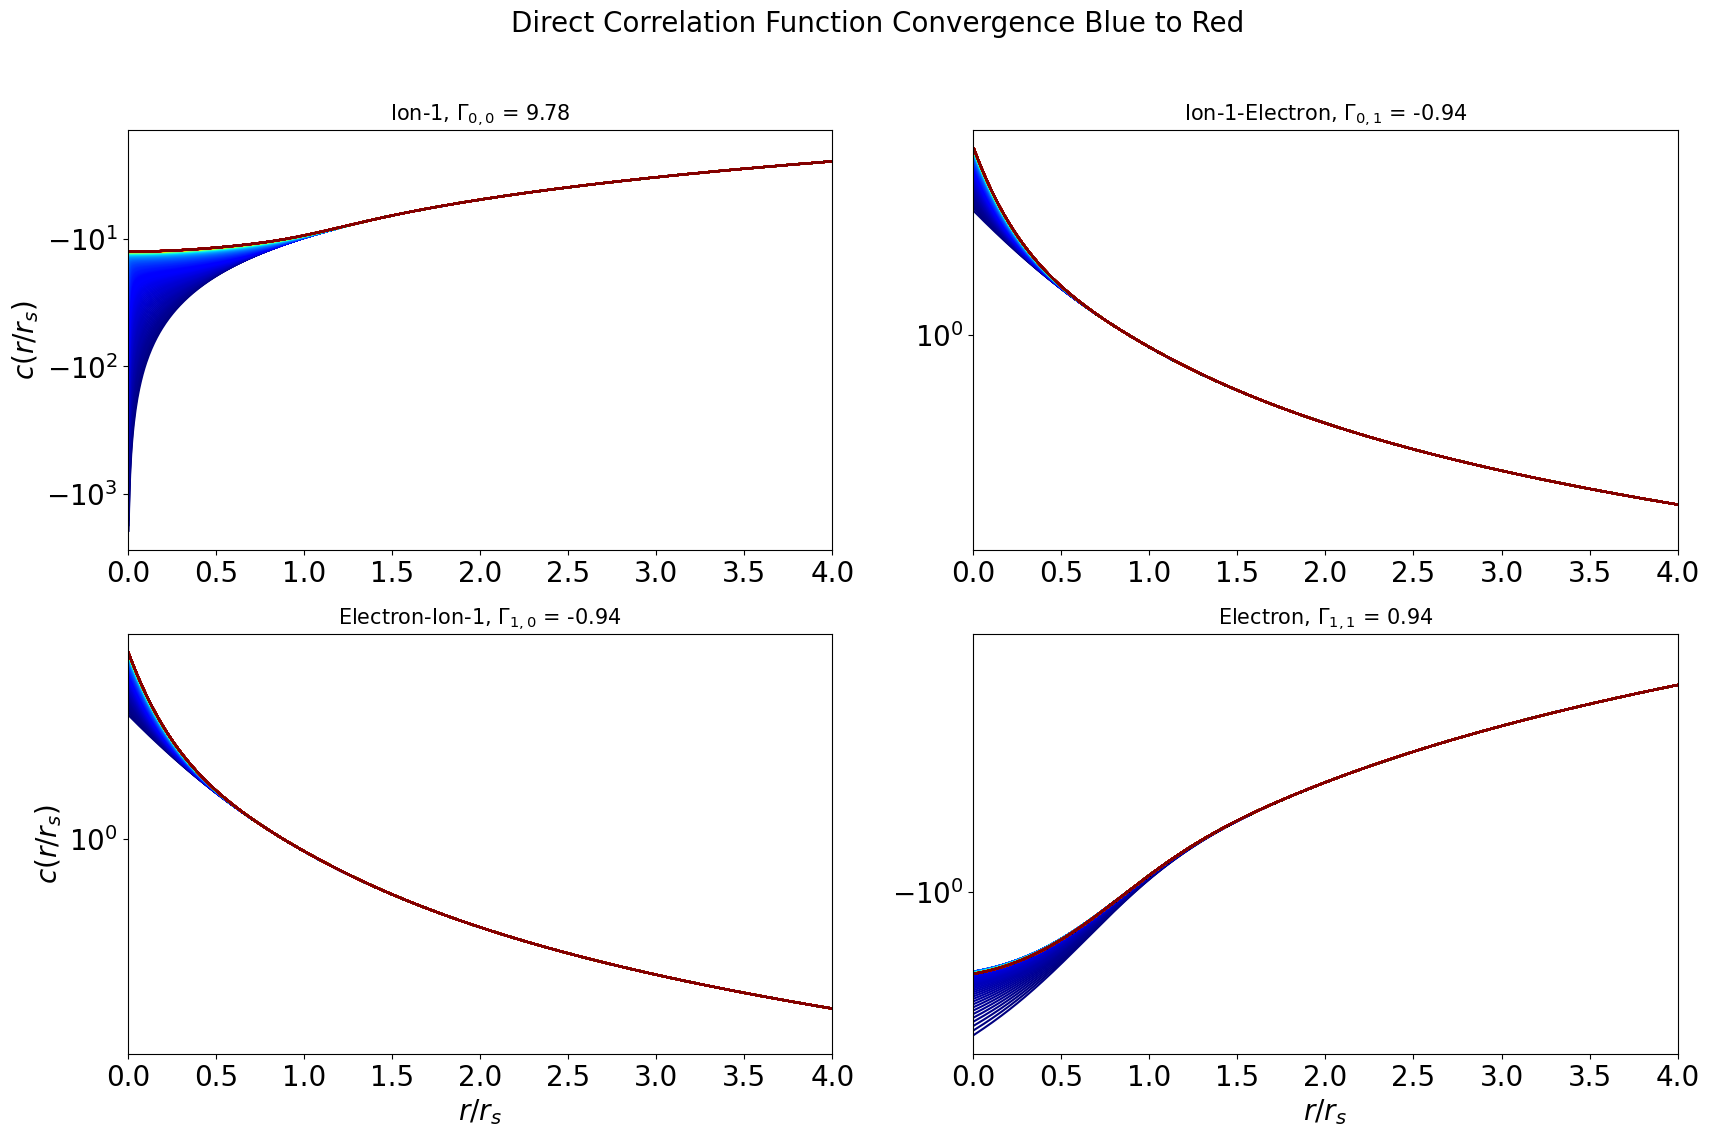

In [16]:
hydrogen.plot_species_convergence_g(n_slices= int(len(hydrogen.h_list)/1)  )
hydrogen.plot_species_convergence_c(n_slices= int(len(hydrogen.h_list)/1)  )

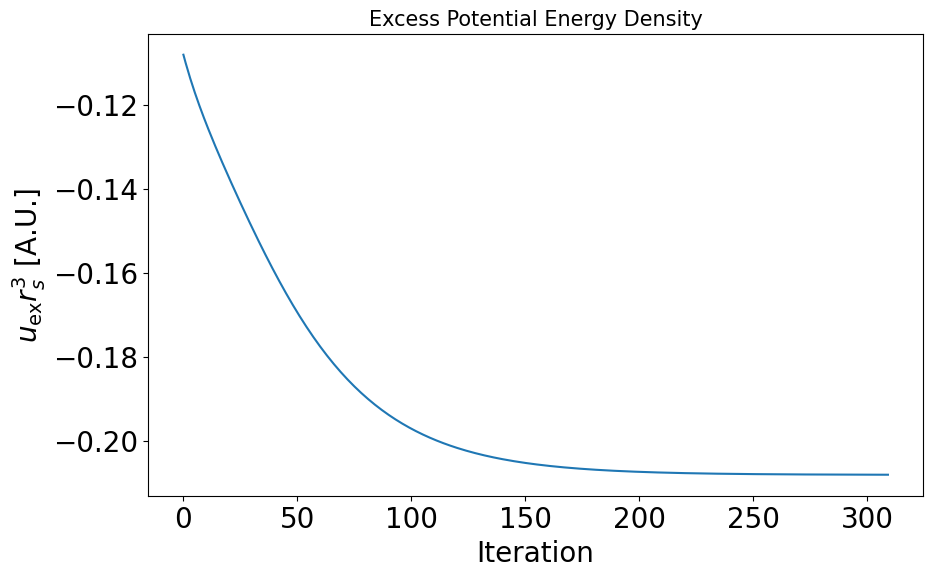

In [19]:
hydrogen.plot_convergence_uex()

In [23]:
hydrogen_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar , method='fixed',alpha=0.1)

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
0: Err in c_r: 7.39e+00, OZ: 2.50e-01, HNC: 5.71e-02, tot: 0.33
1: Err in c_r: 6.69e+00, OZ: 2.44e-01, HNC: 4.51e-02, tot: 0.33
2: Err in c_r: 6.05e+00, OZ: 2.38e-01, HNC: 3.83e-02, tot: 0.34
3: Err in c_r: 5.47e+00, OZ: 2.33e-01, HNC: 3.38e-02, tot: 0.34
4: Err in c_r: 4.94e+00, OZ: 2.28e-01, HNC: 3.05e-02, tot: 0.34
5: Err in c_r: 4.47e+00, OZ: 2.23e-01, HNC: 2.81e-02, tot: 0.35
6: Err in c_r: 4.04e+00, OZ: 2.18e-01, HNC: 2.62e-02, tot: 0.35
7: Err in c_r: 3.66e+00, OZ: 2.13e-01, HNC: 2.47e-02, tot: 0.36
8: Err in c_r: 3.31e+00, OZ: 2.08e-01, HNC: 2.34e-02, tot: 0.36
9: Err in c_r: 2.99e+00, OZ: 2.04e-01, HNC: 2.24e-02, tot: 0.36
10: Err in c_r: 2.70e+00, OZ: 2.00e-01, HNC: 2.16e-02, tot: 0.37
11: Err in c_r: 2.44e+00, OZ: 1.96e-01, HNC: 2.09e-02, tot: 0.37
12: Err in c_r: 2.21e+00, OZ: 1.91e-01, HNC: 2.03e-02, tot: 0.37
13: Err in c_r: 2.00e+00, OZ: 1.87e-01, HNC: 1.98e-02, tot: 0.38
14: Err i

167: Err in c_r: 1.06e-03, OZ: 4.15e-03, HNC: 5.58e-04, tot: 0.47
168: Err in c_r: 1.04e-03, OZ: 4.04e-03, HNC: 5.43e-04, tot: 0.47
169: Err in c_r: 1.01e-03, OZ: 3.93e-03, HNC: 5.28e-04, tot: 0.47
170: Err in c_r: 9.80e-04, OZ: 3.83e-03, HNC: 5.14e-04, tot: 0.47
171: Err in c_r: 9.54e-04, OZ: 3.73e-03, HNC: 5.01e-04, tot: 0.47
172: Err in c_r: 9.28e-04, OZ: 3.63e-03, HNC: 4.87e-04, tot: 0.47
173: Err in c_r: 9.03e-04, OZ: 3.53e-03, HNC: 4.74e-04, tot: 0.47
174: Err in c_r: 8.78e-04, OZ: 3.44e-03, HNC: 4.62e-04, tot: 0.47
175: Err in c_r: 8.54e-04, OZ: 3.35e-03, HNC: 4.49e-04, tot: 0.47
176: Err in c_r: 8.31e-04, OZ: 3.26e-03, HNC: 4.37e-04, tot: 0.47
177: Err in c_r: 8.09e-04, OZ: 3.17e-03, HNC: 4.26e-04, tot: 0.47
178: Err in c_r: 7.87e-04, OZ: 3.08e-03, HNC: 4.14e-04, tot: 0.47
179: Err in c_r: 7.65e-04, OZ: 3.00e-03, HNC: 4.03e-04, tot: 0.47
180: Err in c_r: 7.45e-04, OZ: 2.92e-03, HNC: 3.93e-04, tot: 0.47
181: Err in c_r: 7.24e-04, OZ: 2.84e-03, HNC: 3.82e-04, tot: 0.47
182: Err i

330: Err in c_r: 1.25e-05, OZ: 4.97e-05, HNC: 6.68e-06, tot: 0.47
331: Err in c_r: 1.22e-05, OZ: 4.84e-05, HNC: 6.50e-06, tot: 0.47
332: Err in c_r: 1.18e-05, OZ: 4.71e-05, HNC: 6.33e-06, tot: 0.47
333: Err in c_r: 1.15e-05, OZ: 4.58e-05, HNC: 6.16e-06, tot: 0.47
334: Err in c_r: 1.12e-05, OZ: 4.46e-05, HNC: 6.00e-06, tot: 0.47
335: Err in c_r: 1.09e-05, OZ: 4.34e-05, HNC: 5.83e-06, tot: 0.47
336: Err in c_r: 1.06e-05, OZ: 4.22e-05, HNC: 5.68e-06, tot: 0.47
337: Err in c_r: 1.03e-05, OZ: 4.11e-05, HNC: 5.53e-06, tot: 0.47
338: Err in c_r: 1.00e-05, OZ: 4.00e-05, HNC: 5.38e-06, tot: 0.47
339: Err in c_r: 9.78e-06, OZ: 3.89e-05, HNC: 5.23e-06, tot: 0.47


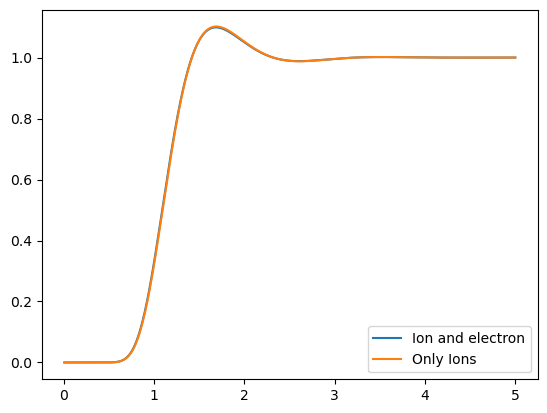

In [24]:
fig, ax = plt.subplots()

ax.plot(hydrogen.r_array, hydrogen.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(hydrogen.r_array, hydrogen_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



## Aluminum

In [5]:
K_to_eV = 1/11606.

In [6]:
ni = 6.03e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 13,27
Zstar= 3
# aluminum_i_one_species,_ = run_hnc_one_ion(ni, Te, Z, A, Zstar, num_iterations=1e3,method='fixed' ,alpha=0.1)
# aluminum_e_one_species,_ = run_hnc_one_electron(Zstar*ni, Te, 1, m_e/m_p, 1, num_iterations=1e3,method='fixed',alpha=0.1 )


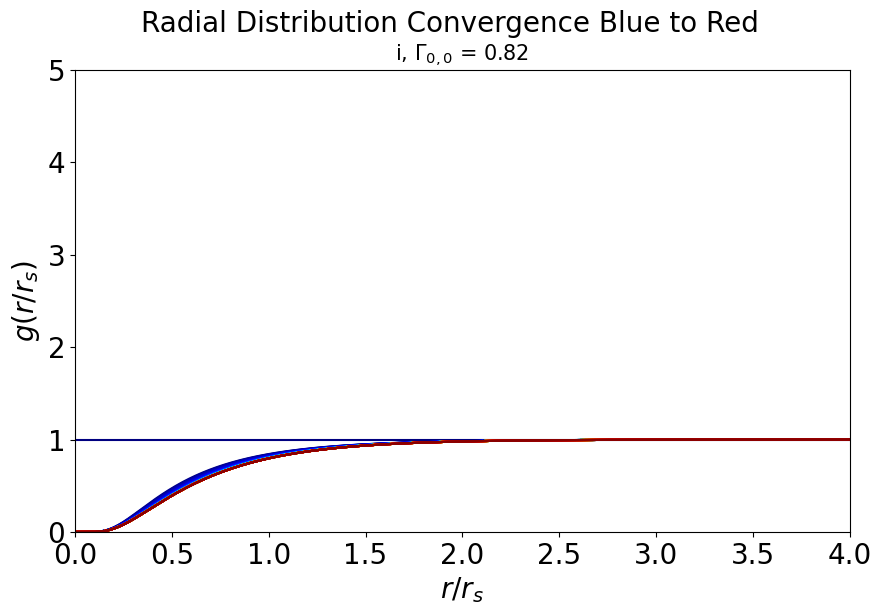

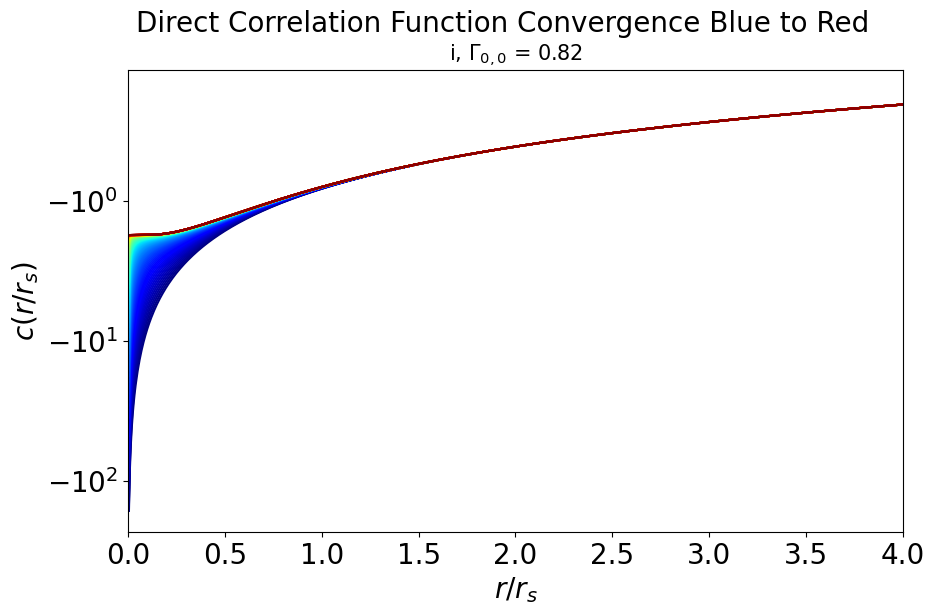

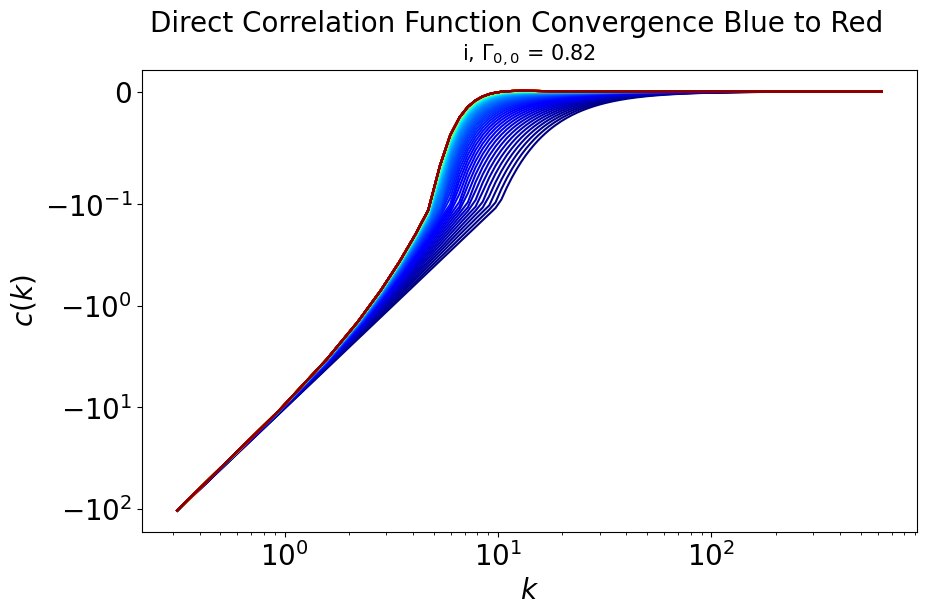

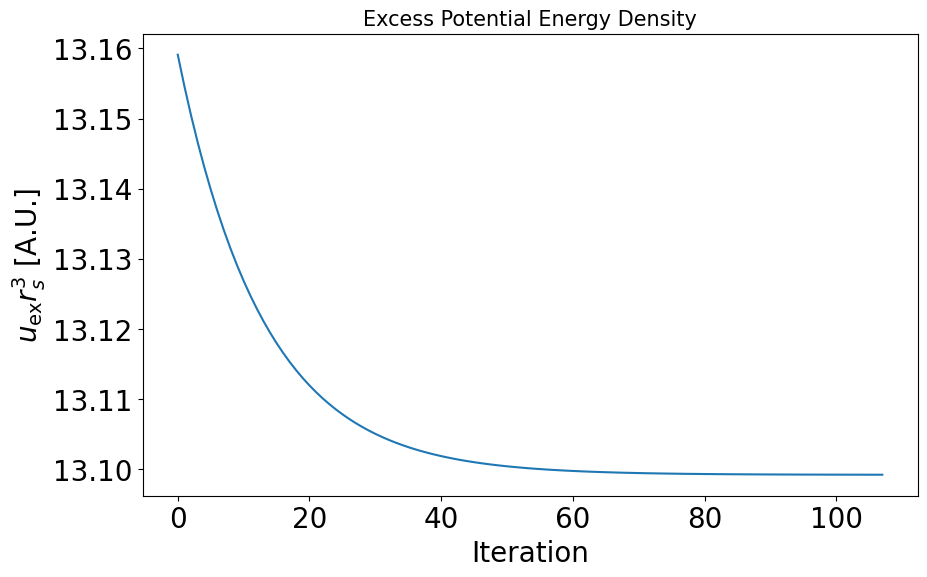

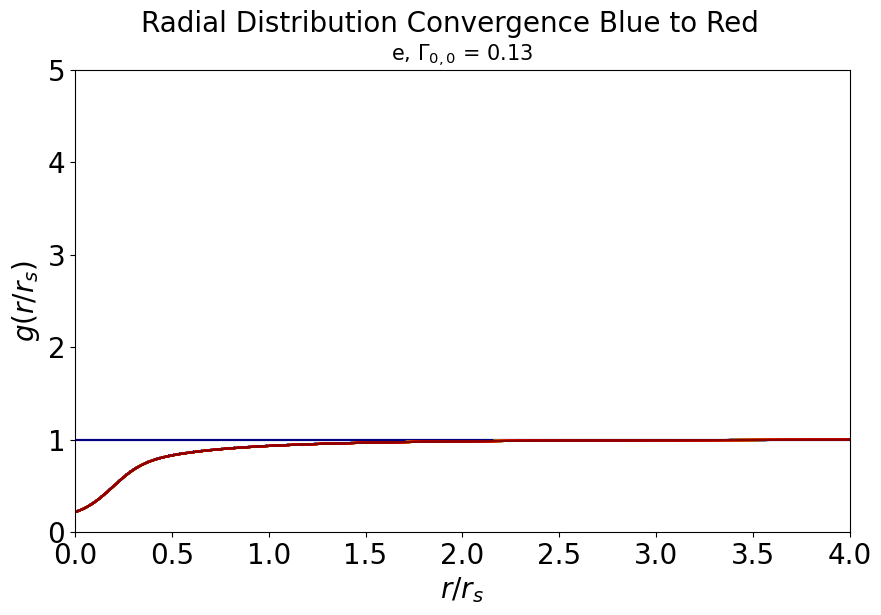

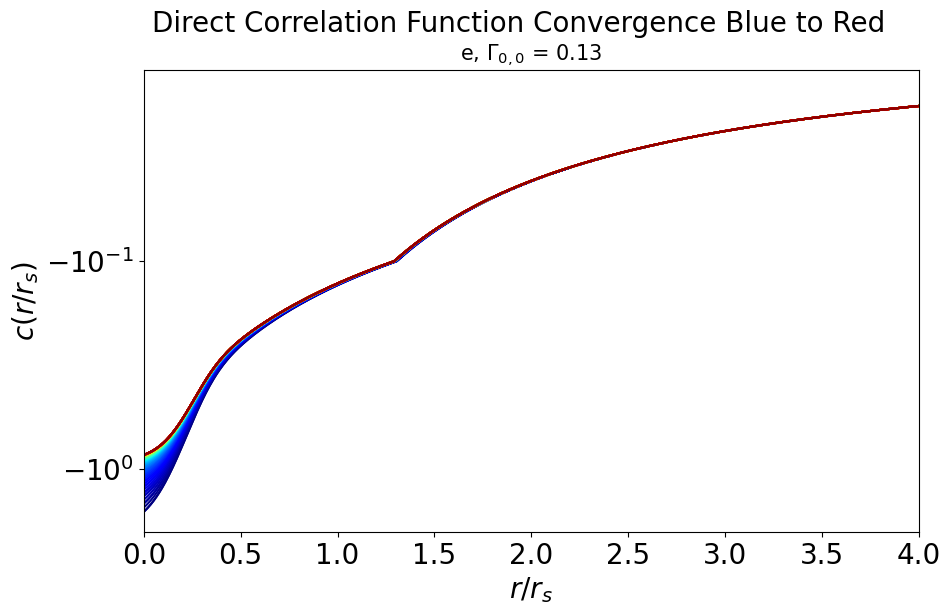

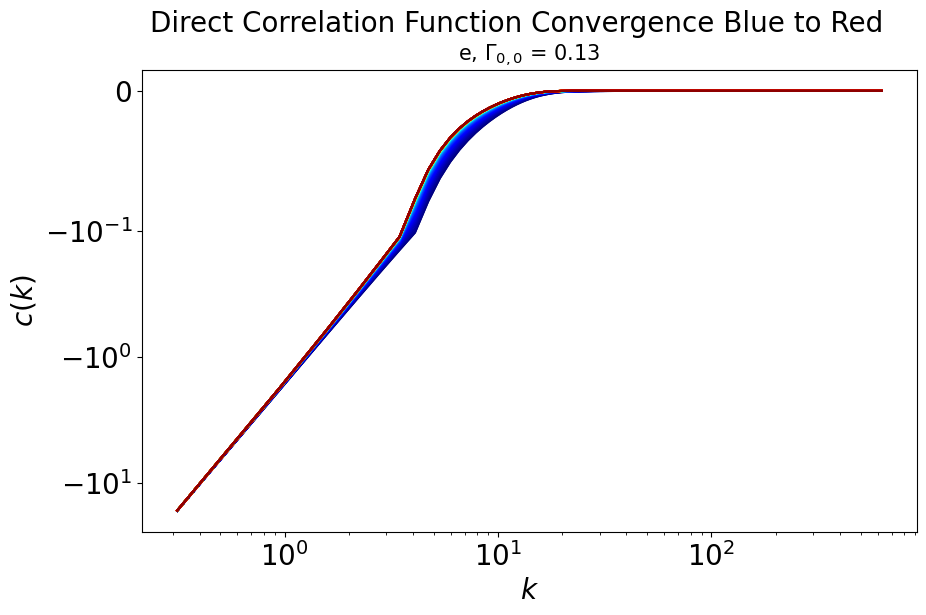

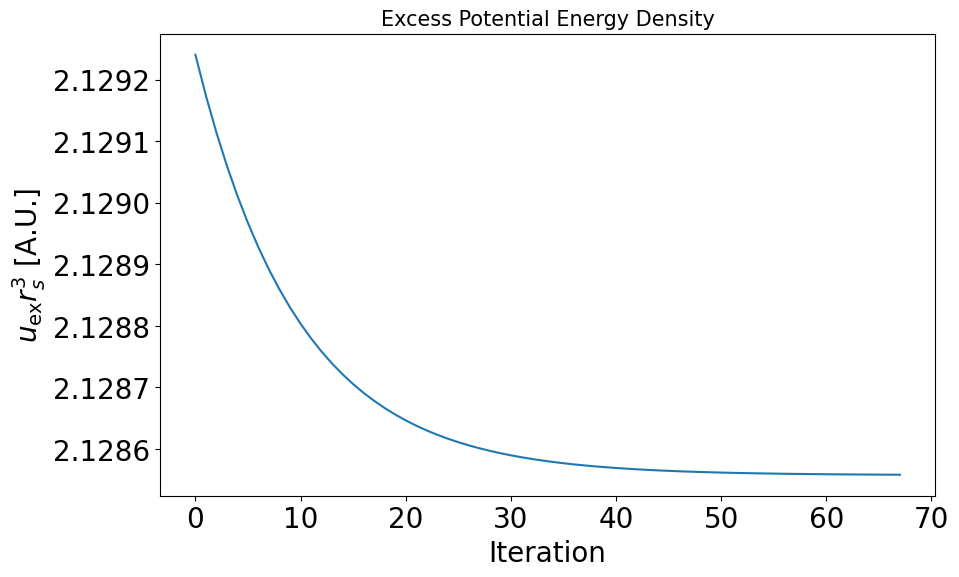

In [95]:
aluminum_i_one_species.plot_species_convergence_g(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_i_one_species.plot_species_convergence_c(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_i_one_species.plot_species_convergence_ck(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_i_one_species.plot_convergence_uex()

aluminum_e_one_species.plot_species_convergence_g(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_e_one_species.plot_species_convergence_c(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_e_one_species.plot_species_convergence_ck(n_slices= int(len(aluminum_i_one_species.h_list)/1)  )
aluminum_e_one_species.plot_convergence_uex()

In [96]:
c_k_guess = np.zeros((2,2,N_bins))
c_k_guess[0,0] = aluminum_i_one_species.c_k_matrix
c_k_guess[1,1] = aluminum_e_one_species.c_k_matrix

In [15]:
aluminum, aluminumqsp = run_hnc(ni, Te, Z, A, Zstar, num_iterations=214, method='fixed', alpha=1e-1)#, c_k_guess=c_k_guess )

Λee = 0.313
Λei = 0.222
Γii=81.917, Γie=-2.769, Γee=0.923 
r_i=2.989
r_e=2.073
θ  =8.57e-02
0: Err in c_r: 2.83e+01, OZ: 2.57e-01, HNC: 1.70e+03, tot: 0.62
1: Err in c_r: 2.58e+01, OZ: 2.53e-01, HNC: 2.67e+02, tot: 0.57
2: Err in c_r: 2.34e+01, OZ: 2.50e-01, HNC: 7.84e+01, tot: 0.55
3: Err in c_r: 2.13e+01, OZ: 2.47e-01, HNC: 3.40e+01, tot: 0.53
4: Err in c_r: 1.94e+01, OZ: 2.44e-01, HNC: 1.91e+01, tot: 0.53
5: Err in c_r: 1.77e+01, OZ: 2.42e-01, HNC: 1.29e+01, tot: 0.53
6: Err in c_r: 1.61e+01, OZ: 2.39e-01, HNC: 9.90e+00, tot: 0.53
7: Err in c_r: 1.46e+01, OZ: 2.37e-01, HNC: 8.41e+00, tot: 0.54
8: Err in c_r: 1.33e+01, OZ: 2.34e-01, HNC: 7.71e+00, tot: 0.56
9: Err in c_r: 1.21e+01, OZ: 2.32e-01, HNC: 7.50e+00, tot: 0.57
10: Err in c_r: 1.10e+01, OZ: 2.30e-01, HNC: 7.65e+00, tot: 0.59
11: Err in c_r: 1.00e+01, OZ: 2.28e-01, HNC: 8.10e+00, tot: 0.60
12: Err in c_r: 9.14e+00, OZ: 2.26e-01, HNC: 8.85e+00, tot: 0.62
13: Err in c_r: 8.32e+00, OZ: 2.25e-01, HNC: 9.92e+00, tot: 0.65
14: Err 

133: Err in c_r: 1.02e-01, OZ: 1.45e-01, HNC: 4.89e+05, tot: 8.11
134: Err in c_r: 1.00e-01, OZ: 1.44e-01, HNC: 4.51e+05, tot: 8.16
135: Err in c_r: 9.94e-02, OZ: 1.44e-01, HNC: 4.17e+05, tot: 8.22
136: Err in c_r: 9.83e-02, OZ: 1.43e-01, HNC: 3.85e+05, tot: 8.28
137: Err in c_r: 9.73e-02, OZ: 1.43e-01, HNC: 3.57e+05, tot: 8.33
138: Err in c_r: 9.63e-02, OZ: 1.42e-01, HNC: 3.30e+05, tot: 8.39
139: Err in c_r: 9.53e-02, OZ: 1.41e-01, HNC: 3.07e+05, tot: 8.44
140: Err in c_r: 9.43e-02, OZ: 1.41e-01, HNC: 2.85e+05, tot: 8.50
141: Err in c_r: 9.33e-02, OZ: 1.40e-01, HNC: 2.66e+05, tot: 8.55
142: Err in c_r: 9.23e-02, OZ: 1.39e-01, HNC: 2.48e+05, tot: 8.60
143: Err in c_r: 9.14e-02, OZ: 1.39e-01, HNC: 2.32e+05, tot: 8.66
144: Err in c_r: 9.05e-02, OZ: 1.38e-01, HNC: 2.17e+05, tot: 8.71
145: Err in c_r: 8.96e-02, OZ: 1.38e-01, HNC: 2.04e+05, tot: 8.77
146: Err in c_r: 8.87e-02, OZ: 1.37e-01, HNC: 1.93e+05, tot: 8.82
147: Err in c_r: 8.79e-02, OZ: 1.36e-01, HNC: 1.82e+05, tot: 8.87
148: Err i

In [16]:
aluminumqsp.Te, aluminumqsp.Te_c, aluminumqsp.Tq, aluminumqsp.Ti 

(0.0367512, 0.36242319501279524, 0.3605550187999643, 0.0367512)

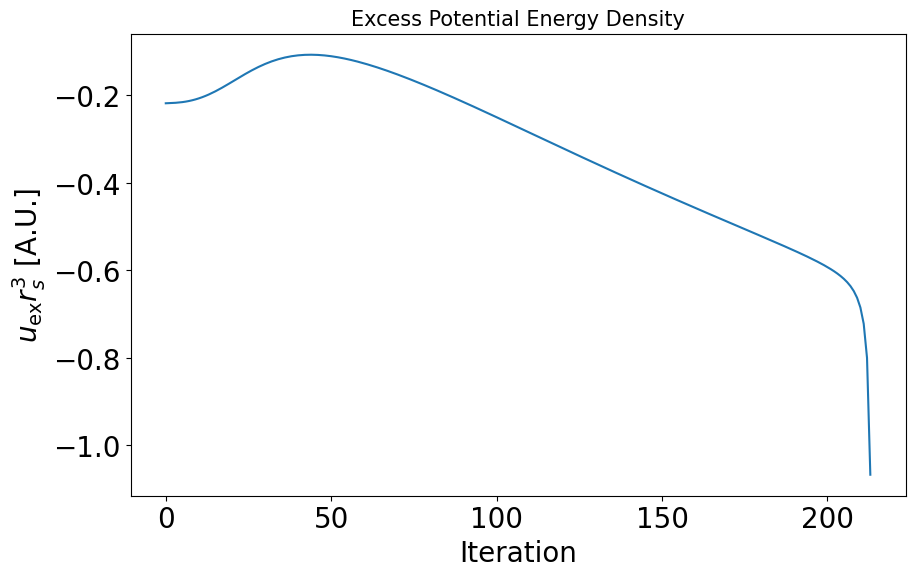

In [17]:
aluminum.plot_convergence_uex()


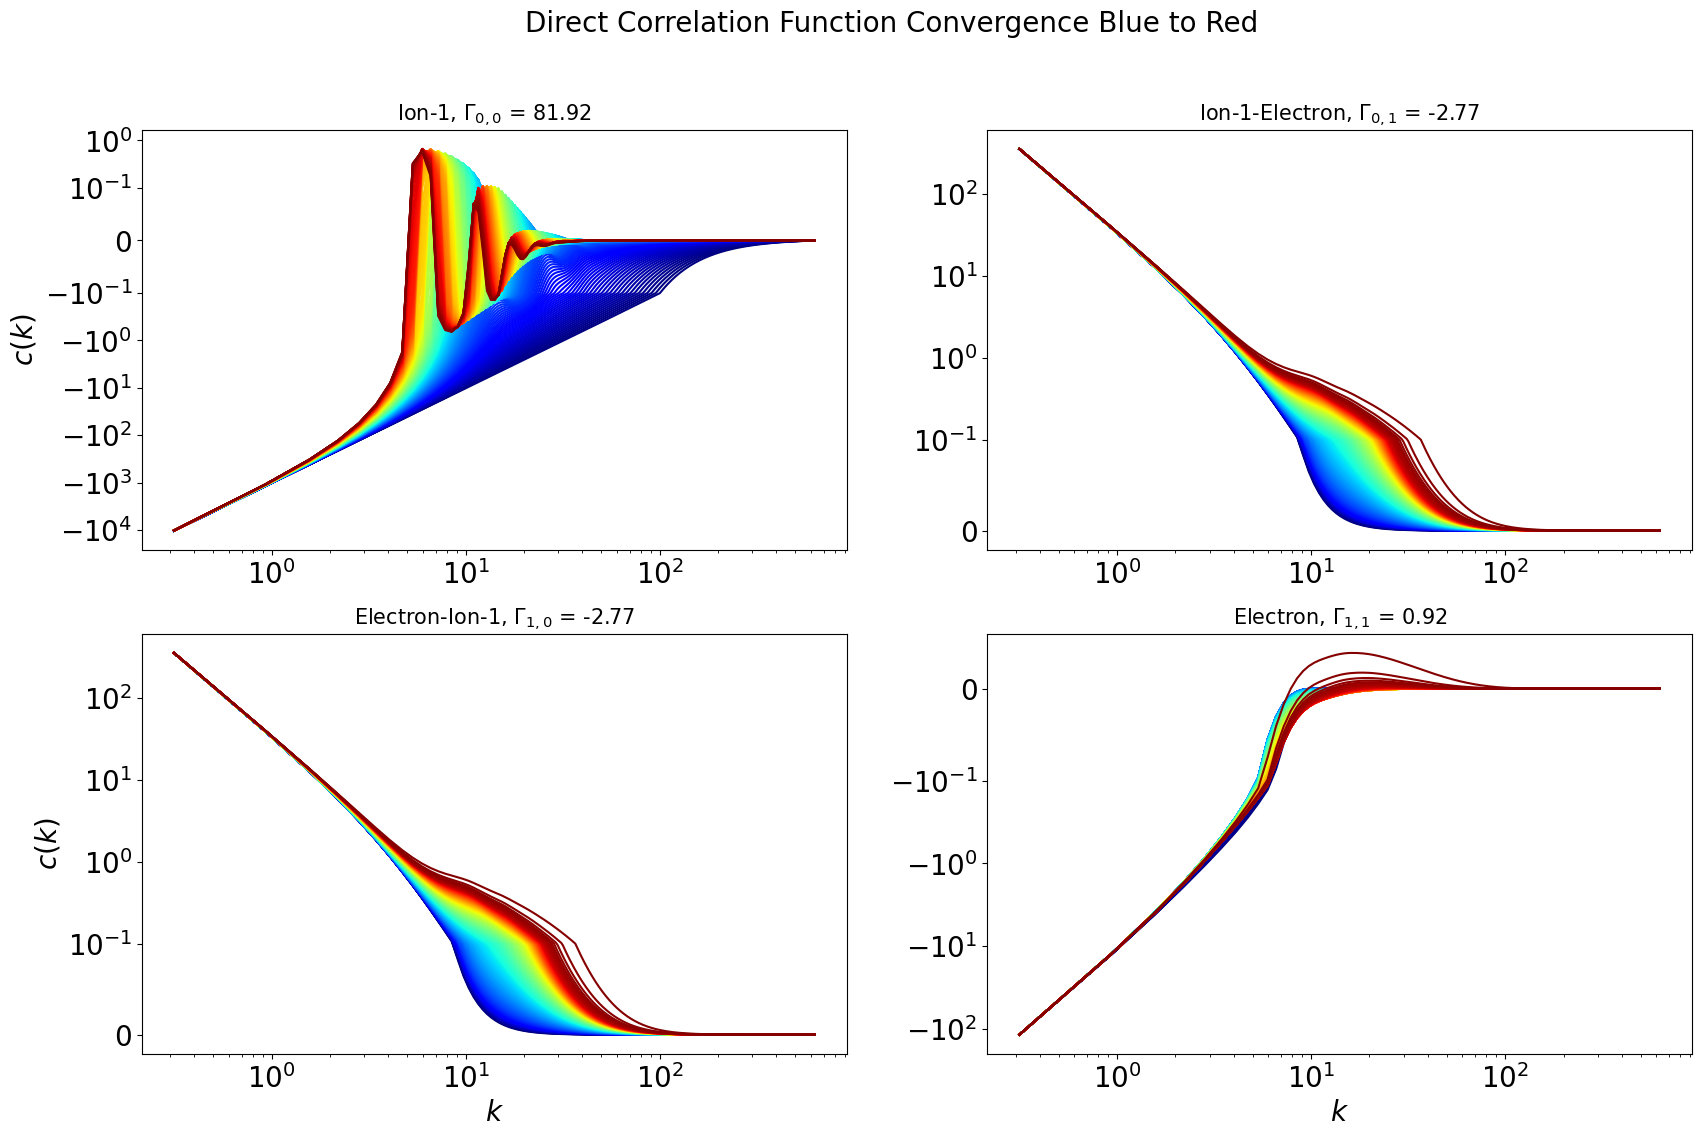

In [18]:
aluminum.plot_species_convergence_ck(n_slices= int(len(aluminum.h_list)/1)  )

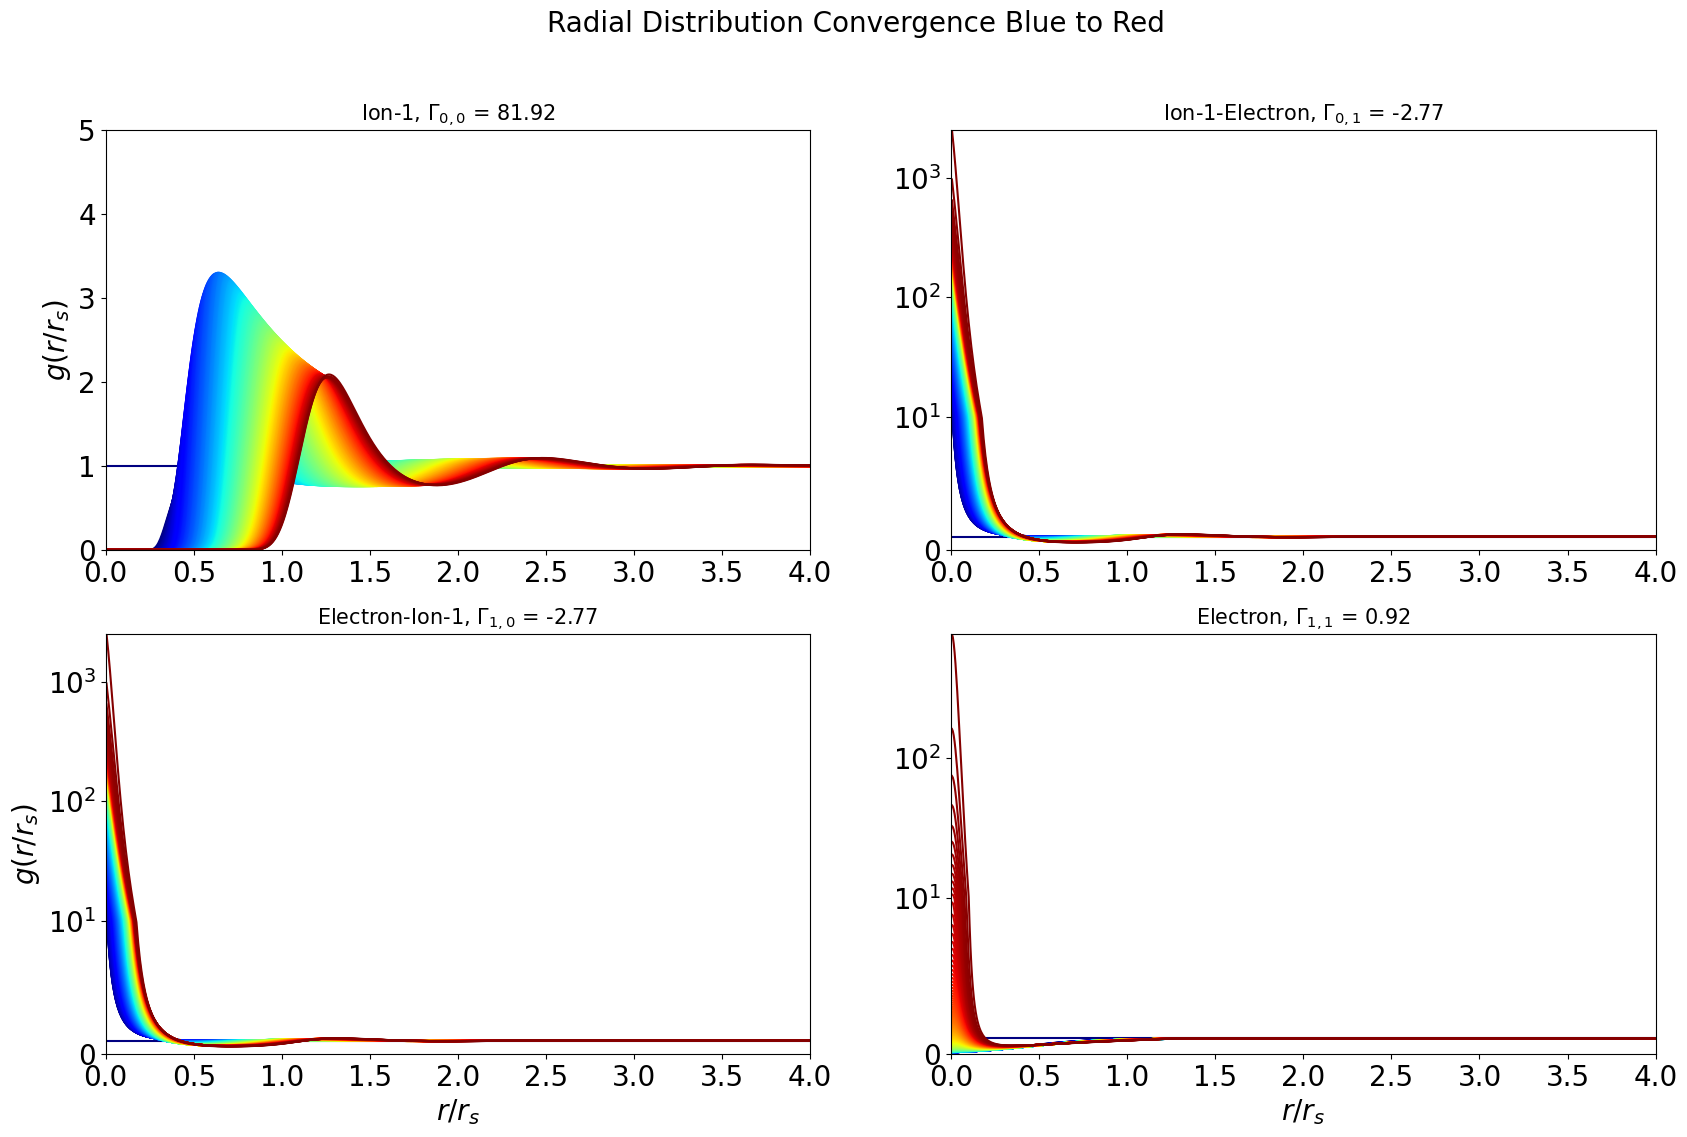

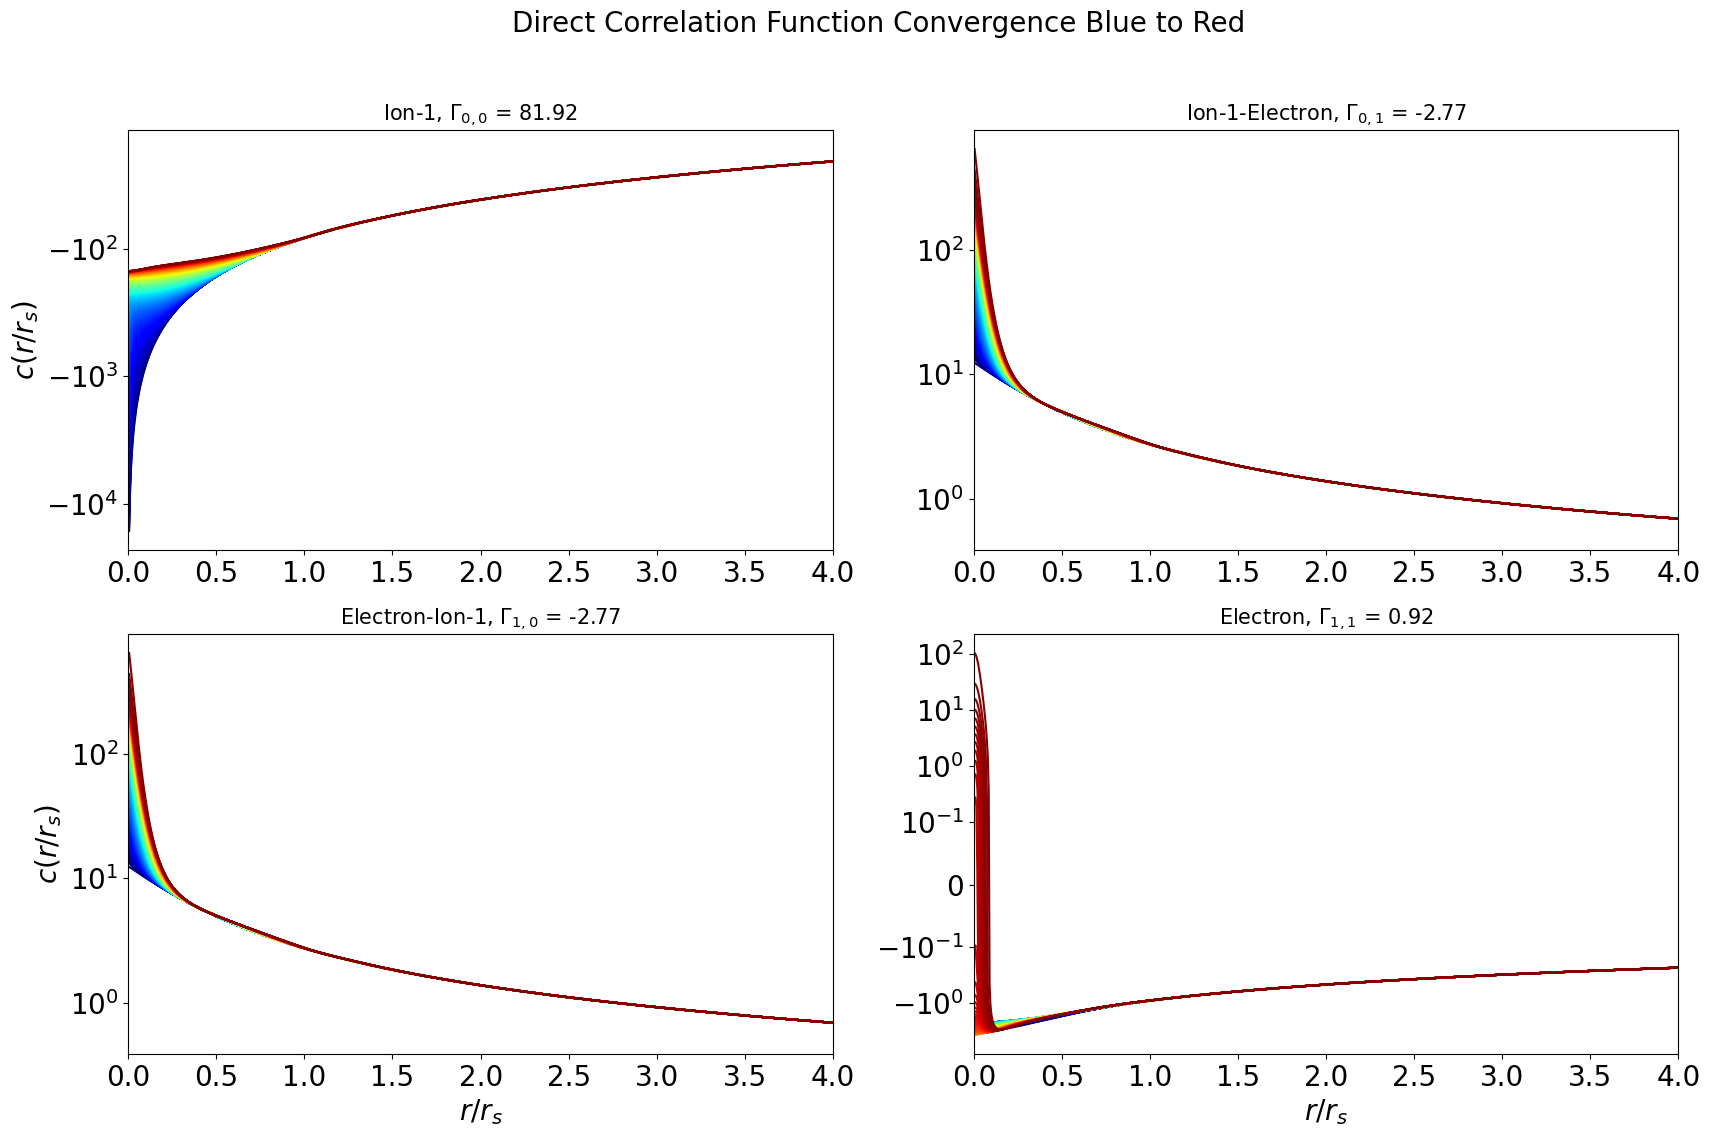

In [19]:
aluminum.plot_species_convergence_g(n_slices= int(len(aluminum.h_list)/1)  )
aluminum.plot_species_convergence_c(n_slices= int(len(aluminum.h_list)/1)  )
